In [9]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from coffea import util

In [11]:
from pltStyle import pltStyle
pltStyle(style='paper')
plt.rcParams['figure.subplot.left'] = 0.162
plt.rcParams['figure.dpi'] = 150

In [12]:
### Some recent file to get out the binning
outname = 'out/CoffeaJERCOutputs_L5_fine_etaBins_QCD.coffea'
output = util.load(outname)

In [13]:
f_xvals = np.linspace(0,5,5001)

ptbins = output['ptresponse'].axis('pt').edges()
ptbins_c = output['ptresponse'].axis('pt').centers()
etabins = np.array([-5, -3, -2.5, -1.3, 0, 1.3, 2.5, 3, 5])
    

# jetpt_length = len(ptbins)-1
# jeteta_length = (len(etabins)-1)//2

etabins_mod = etabins[(len(etabins)-1)//2:]
etabins_c = (etabins_mod[:-1]+etabins_mod[1:])/2 #output['ptresponse'].axis('jeteta').centers()

In [14]:
def read_data(name, samp, tag_full):
    df_csv = pd.read_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv').set_index('etaBins')
    data = df_csv.to_numpy().transpose()
    return data

In [15]:
def make_comparison_plot(yvar1, std1, yvar2, std2, k, samp, name1:str, name2:str):
    ''' Make a coparison and a ratio plot of yvar2 vs yvar1
    '''
    
    inverse = False
    
    mean_p_QCD = yvar1.copy()
    mean_p_QCD[(mean_p_QCD==0) | (np.abs(mean_p_QCD)==np.inf)] = np.nan
    
    mean_p_TTBAR = yvar2.copy()
    mean_p_TTBAR[(mean_p_TTBAR==0) | (np.abs(mean_p_TTBAR)==np.inf)] = np.nan
    
    fig = plt.figure()
    gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0, height_ratios=[3, 1])
    ax = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    start = np.where(ptbins<=20)[0][-1]

    for axis in [ax.xaxis, ax.yaxis, ax2.xaxis, ax2.yaxis]:
        axis.set_minor_locator(mpl.ticker.AutoMinorLocator())

    xvals = (ptbins[start:-1] + ptbins[start+1:])/2
    wd = np.abs(ptbins[start:-1] - ptbins[start+1:])
    QCD_vals = mean_p_QCD[start:,k]
    TTbar_vals = mean_p_TTBAR[start:,k]
    
    ### Replacing response values to corrections
    if inverse==True:
        TTbar_vals = 1/TTbar_vals
        QCD_vals = 1/QCD_vals
    
    std1 = std1[start:,k]
    std2 = std2[start:,k]
    
    ### Error propagation
    if inverse==True:
        std1 = QCD_vals**2*std1
        std2 = TTbar_vals**2*std2
    
#     print(xvals)
#     print(QCD_vals)
#     print(std1)
    p1 = ax.errorbar(xvals, QCD_vals, yerr=std1, marker='o', color="k",
#                      markerfacecolor='none', markeredgewidth=1,
                 linestyle="none", label=name1)

    p5 = ax.errorbar(xvals, TTbar_vals, yerr=std2, marker='v',
#                      markerfacecolor='none', markeredgewidth=1, color=p1.lines[0].get_color(),
                 linestyle="none", label=name2)

    
    ax2.hlines(1,1, 10000, linestyles='--',color="black",
        linewidth=1,)
    rel_mc_unc =  std1/QCD_vals 

    ax2.bar(
        xvals,
        2 * rel_mc_unc,
        width=wd,
        bottom=1.0 - rel_mc_unc,
        fill=False,
        linewidth=0,
        edgecolor="gray",
        hatch=10 * "/",
    )


    # data in ratio plot
    data_model_ratio = TTbar_vals/QCD_vals
    data_model_ratio_unc = std2 / QCD_vals
    # mask data in bins where total model yield is 0
    ax2.errorbar(
        xvals,
        data_model_ratio, #[nonzero_model_yield],
        yerr=data_model_ratio_unc, #[nonzero_model_yield],
        fmt="v",
#         marker='v',
#         color="k",
    )


    ax2.set_ylabel(name2+" /\n "+name1)
    ax2.tick_params(axis="both", which="major", pad=8)
    ax2.tick_params(direction="in", top=True, right=True, which="both")

    fig.set_tight_layout(True)

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([std1, std2 ])
    y_norm = np.concatenate([QCD_vals, TTbar_vals])
    norm_pos = (yerr_norm<0.04) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    left_lim = np.min((y_norm-yerr_norm)[norm_pos])
    right_lim = np.max((yerr_norm+y_norm)[norm_pos])
    lim_pad = (right_lim - left_lim)/10
    ax.set_ylim(left_lim-lim_pad, right_lim+lim_pad)
    #     ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))

    yerr_norm = np.concatenate([std1/QCD_vals, std2/QCD_vals ])
    y_norm = np.concatenate([QCD_vals/QCD_vals, TTbar_vals/QCD_vals])
    norm_pos = (yerr_norm<0.003) &  (yerr_norm != np.inf) & (y_norm>-0.1) 
    left_lim = np.min((y_norm-yerr_norm)[norm_pos])
    right_lim = np.max((yerr_norm+y_norm)[norm_pos])
    lim_pad = (right_lim - left_lim)/10
    ax2.set_ylim(left_lim-lim_pad, right_lim+lim_pad)


    ylabel = r'median response' if inverse else  r'correction (1/median response)'
    
    ax2.set_xlabel(r'$p_T$ (GeV)');
    ax.set_ylabel(ylabel); # ax.set_ylabel(r'Correction');
    ax.set_xscale('log')
    ax2.set_xscale('log')

    ax.set_xticks([])
    ax2.set_xticks([20, 50, 100, 200, 500, 1000, 5000])
    ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    leg1 = ax.legend()

    xlims = ax.get_xlim()
    ax.hlines(1,1, 10000, linestyles='--',color="black",
              linewidth=1,)
    
    ax.set_xlim(xlims)
    ax2.set_xlim(xlims)
    eta_string = '_eta'+str(etabins_mod[k])+'to'+str(etabins_mod[k+1])
    eta_string = eta_string.replace('.','')
    print("Saving plot for eta = ", eta_string)
    fig_name = 'fig/corr_vs_pt'+samp+eta_string+'_L5_'+name1+'-'+name2+'-median'
    fig_name = fig_name.replace(', ', '-')
    print("Saving plot with the name = ", fig_name)
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');
    # gs1.tight_layout(fig, rect=[0, 0.1, 0.8, 0.5])
    plt.show();

In [12]:
# # subsamples = ['_b', '_c', '_ud', '_s']

# k2 = np.where(etabins_mod<=0)[0][-1]
# # k4 = np.where(etabins_mod<=1.3)[0][-1]
# # k6 = np.where(etabins_mod<=2.5)[0][-1]
# # k8 = np.where(etabins_mod<=3.0)[0][-1]
# # ks = [k2, k4, k6, k8]
# ks = [k2]

# # ks = [k2, k4] #, k6, k8]
# # subsamples = [''] #, '_b']
# # for samp in subsamples:
# #     for k in ks:
# #         print('Fitting subsample: ', samp)
# #         print('Eta: ', k)
# median_QCD = read_data("Median", '_b', '_L5_LHEflav1_Herwig-TTBAR-JME-100files')
# medianstd_QCD = read_data("MedianStd", '_b', '_L5_LHEflav1_Herwig-TTBAR-JME-100files')
# median_TTBAR = read_data("Median", '_ud', '_L5_LHEflav1_Herwig-TTBAR-JME-200files')
# medianstd_TTBAR = read_data("MedianStd", '_ud', '_L5_LHEflav1_Herwig-TTBAR-JME-200files')
        
        
# make_comparison_plot(median_QCD, medianstd_QCD, median_TTBAR, medianstd_TTBAR,
#                      k, samp, "bottom", "light quark")

Fitting subsample:  _b
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_b_eta00to13_L5_SU16-SU16-cFlip-median


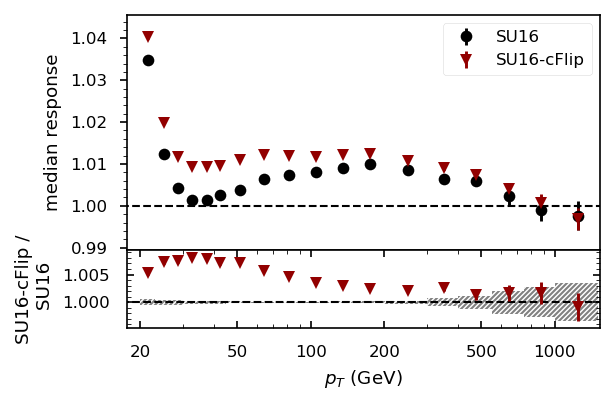

Fitting subsample:  _b
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_b_eta13to25_L5_SU16-SU16-cFlip-median


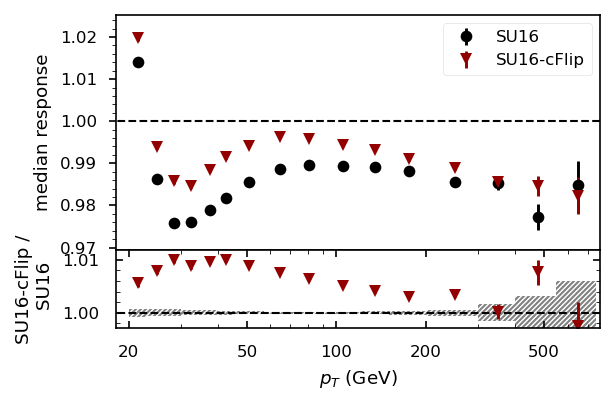

Fitting subsample:  _b
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_b_eta25to30_L5_SU16-SU16-cFlip-median


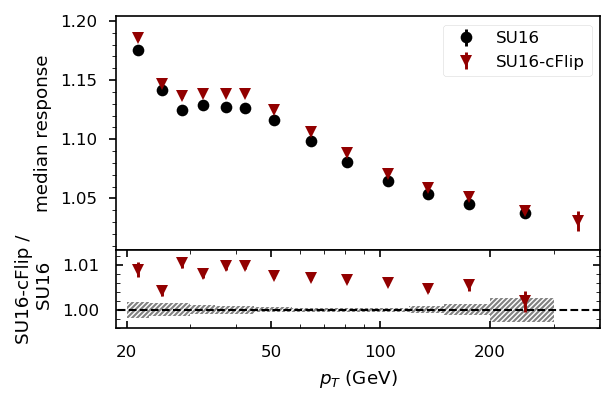

Fitting subsample:  _b
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_b_eta30to50_L5_SU16-SU16-cFlip-median


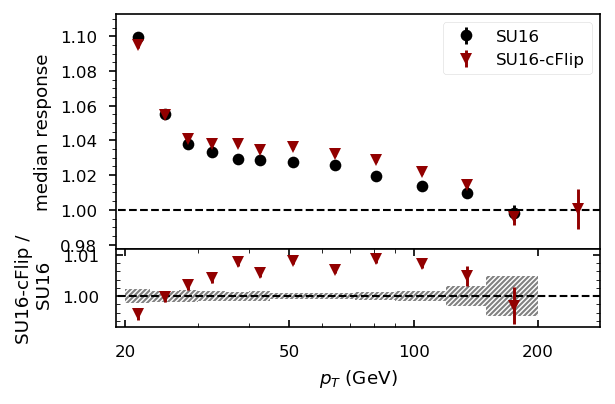

Fitting subsample:  _c
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_c_eta00to13_L5_SU16-SU16-cFlip-median


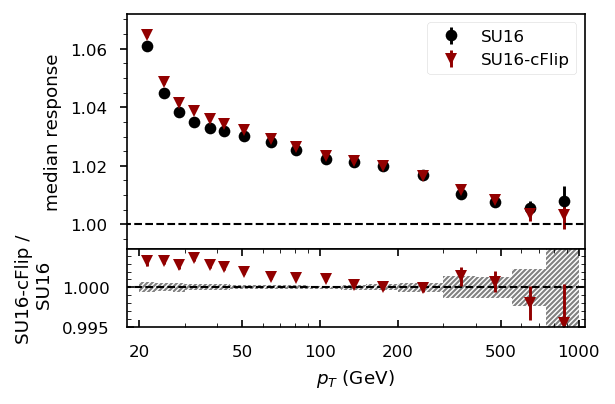

Fitting subsample:  _c
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_c_eta13to25_L5_SU16-SU16-cFlip-median


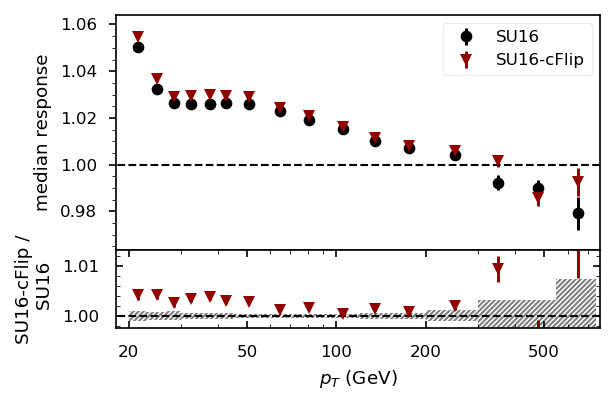

Fitting subsample:  _c
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_c_eta25to30_L5_SU16-SU16-cFlip-median


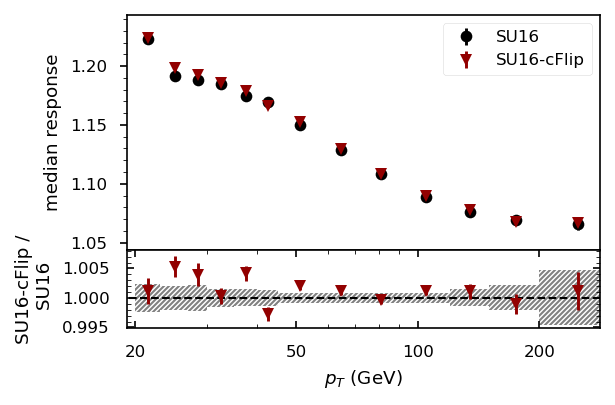

Fitting subsample:  _c
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_c_eta30to50_L5_SU16-SU16-cFlip-median


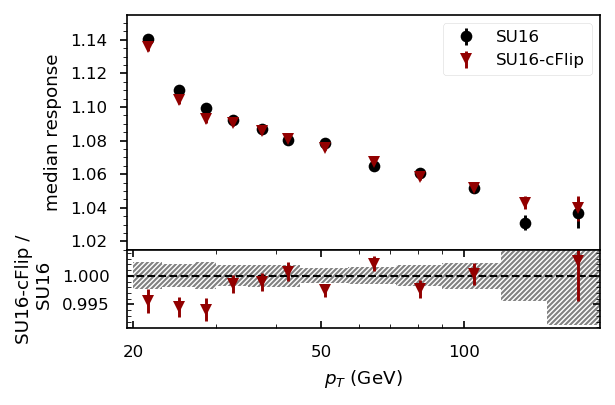

Fitting subsample:  _d
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_d_eta00to13_L5_SU16-SU16-cFlip-median


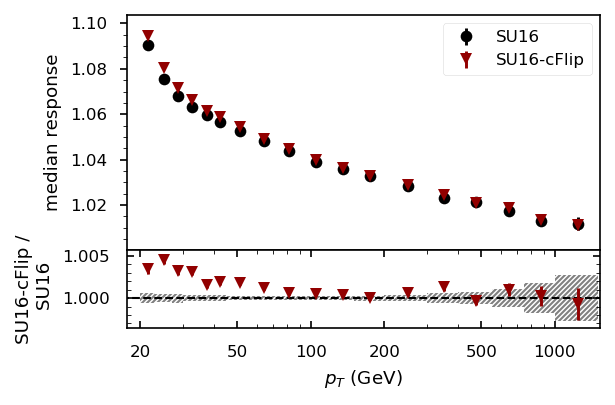

Fitting subsample:  _d
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_d_eta13to25_L5_SU16-SU16-cFlip-median


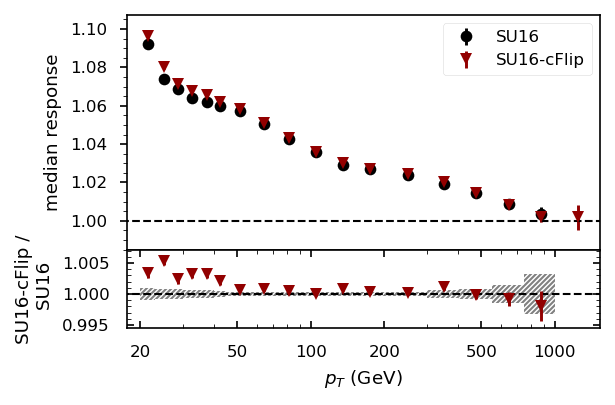

Fitting subsample:  _d
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_d_eta25to30_L5_SU16-SU16-cFlip-median


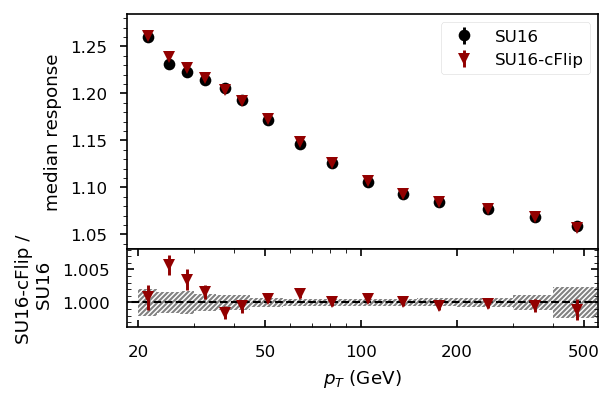

Fitting subsample:  _d
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_d_eta30to50_L5_SU16-SU16-cFlip-median


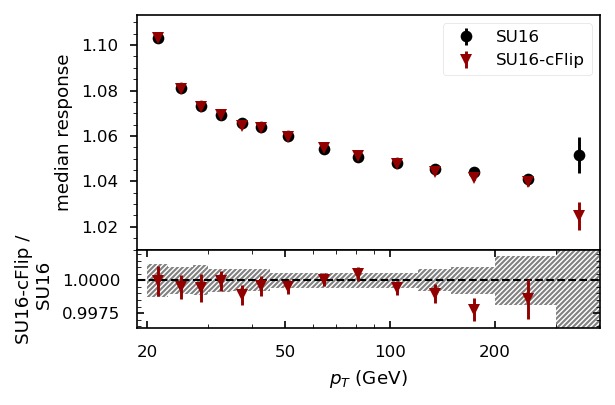

Fitting subsample:  _u
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_u_eta00to13_L5_SU16-SU16-cFlip-median


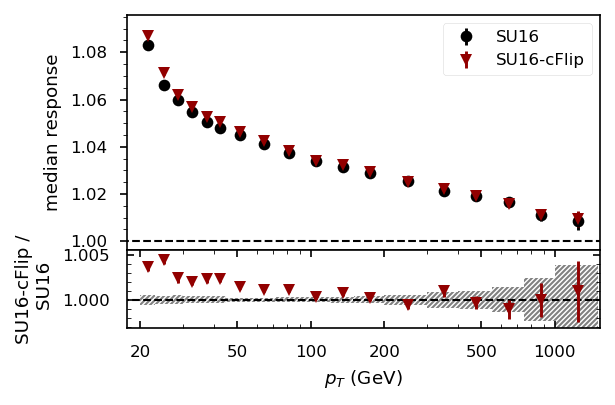

Fitting subsample:  _u
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_u_eta13to25_L5_SU16-SU16-cFlip-median


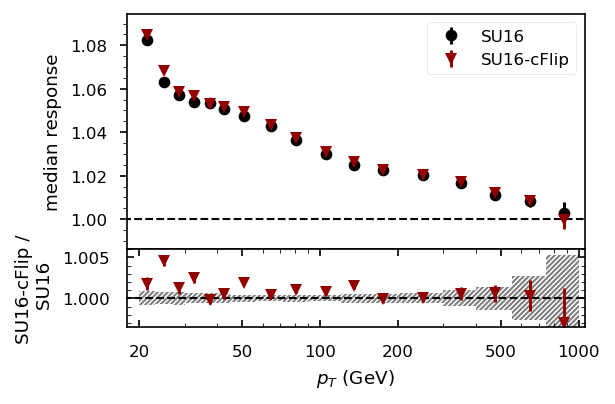

Fitting subsample:  _u
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_u_eta25to30_L5_SU16-SU16-cFlip-median


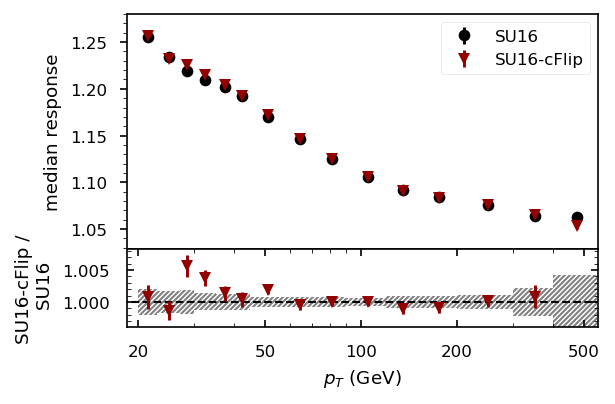

Fitting subsample:  _u
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_u_eta30to50_L5_SU16-SU16-cFlip-median


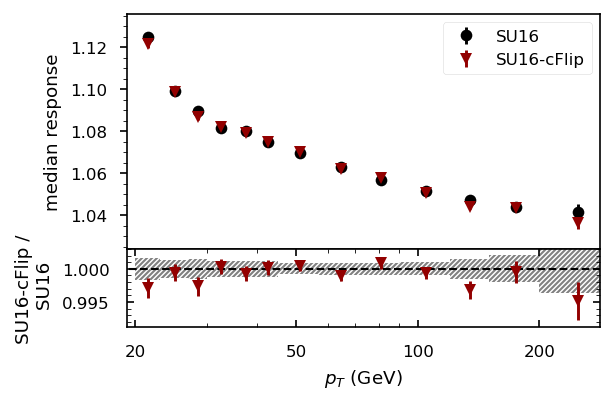

Fitting subsample:  _s
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_s_eta00to13_L5_SU16-SU16-cFlip-median


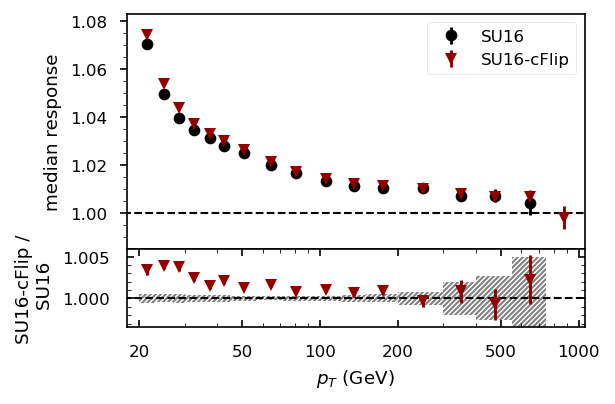

Fitting subsample:  _s
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_s_eta13to25_L5_SU16-SU16-cFlip-median


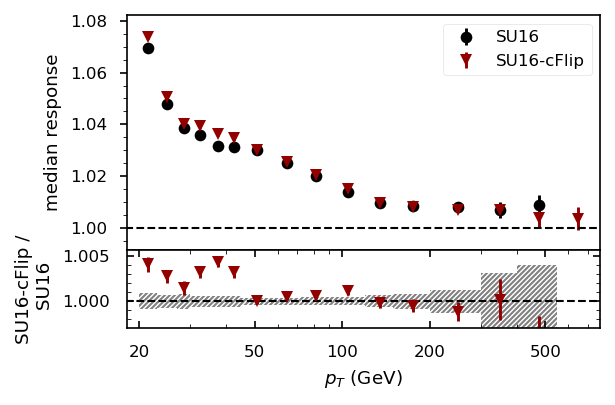

Fitting subsample:  _s
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_s_eta25to30_L5_SU16-SU16-cFlip-median


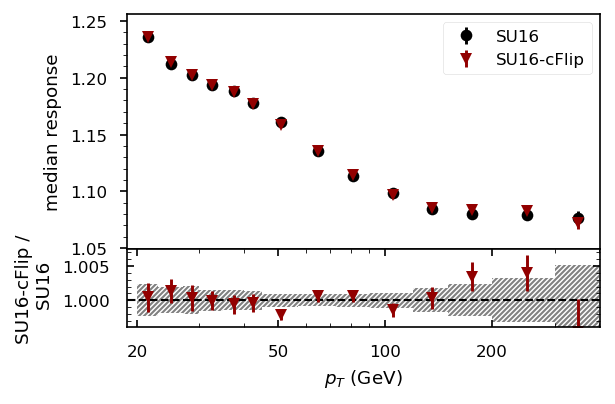

Fitting subsample:  _s
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_s_eta30to50_L5_SU16-SU16-cFlip-median


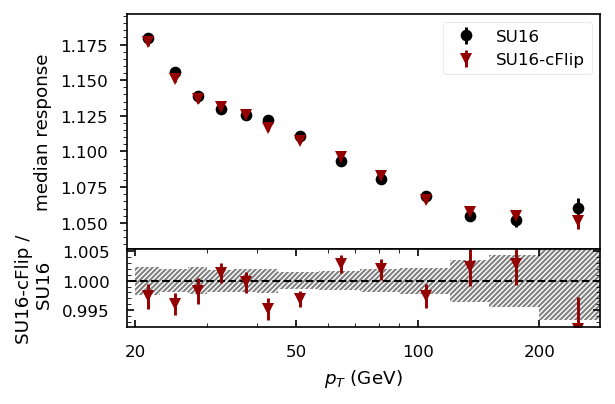

Fitting subsample:  _g
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_g_eta00to13_L5_SU16-SU16-cFlip-median


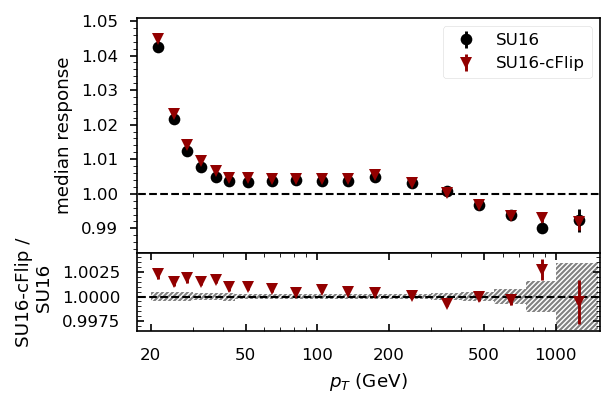

Fitting subsample:  _g
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_g_eta13to25_L5_SU16-SU16-cFlip-median


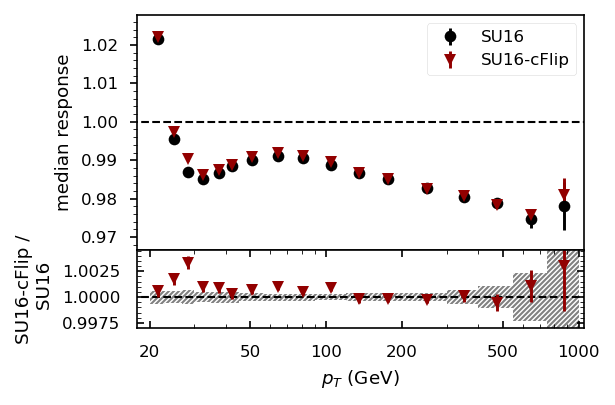

Fitting subsample:  _g
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_g_eta25to30_L5_SU16-SU16-cFlip-median


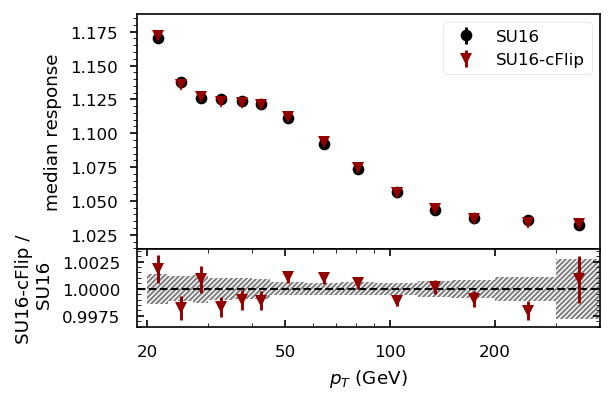

Fitting subsample:  _g
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_g_eta30to50_L5_SU16-SU16-cFlip-median


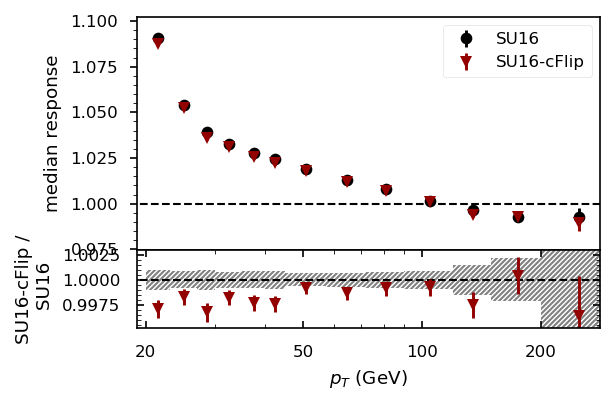

Fitting subsample:  _bbar
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_bbar_eta00to13_L5_SU16-SU16-cFlip-median


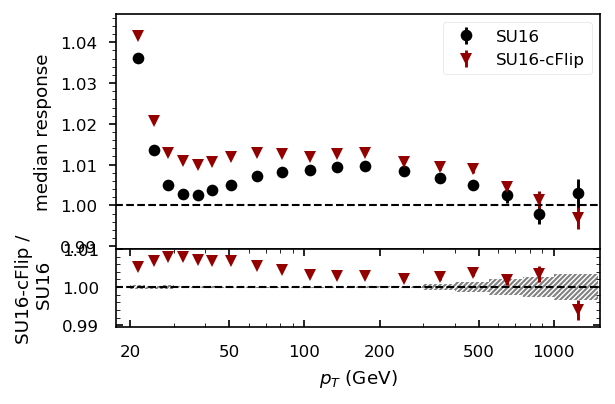

Fitting subsample:  _bbar
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_bbar_eta13to25_L5_SU16-SU16-cFlip-median


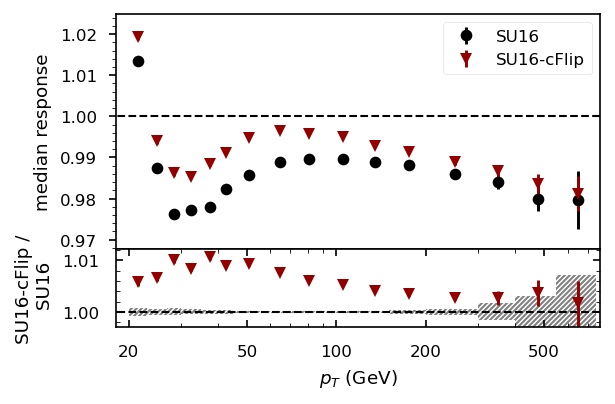

Fitting subsample:  _bbar
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_bbar_eta25to30_L5_SU16-SU16-cFlip-median


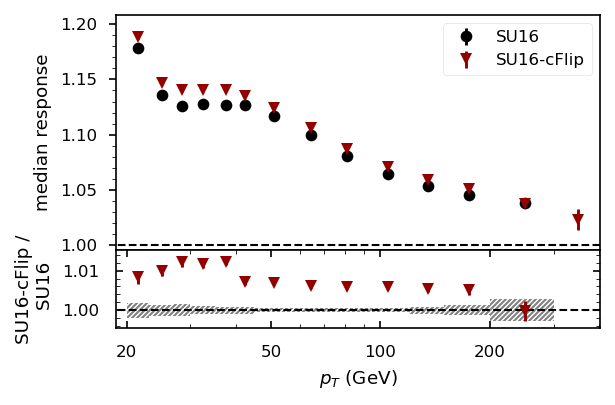

Fitting subsample:  _bbar
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_bbar_eta30to50_L5_SU16-SU16-cFlip-median


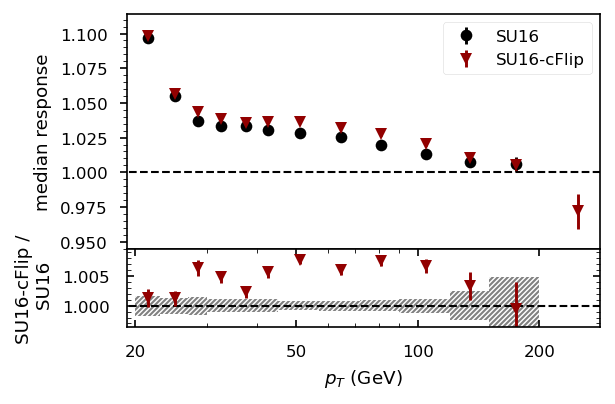

Fitting subsample:  _cbar
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_cbar_eta00to13_L5_SU16-SU16-cFlip-median


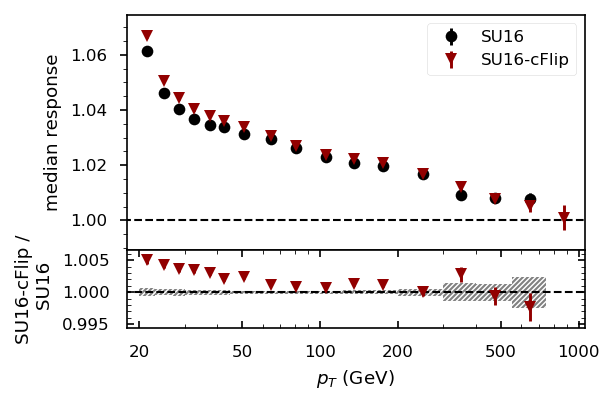

Fitting subsample:  _cbar
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_cbar_eta13to25_L5_SU16-SU16-cFlip-median


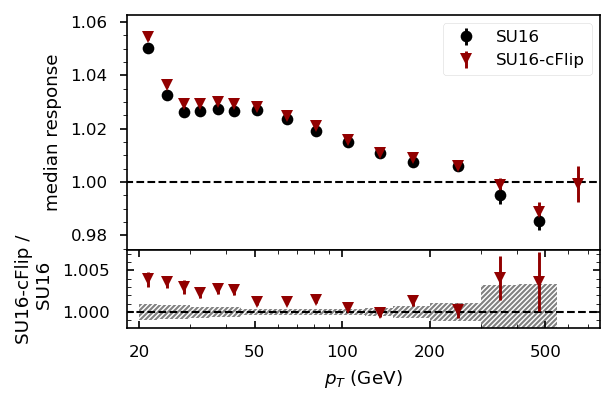

Fitting subsample:  _cbar
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_cbar_eta25to30_L5_SU16-SU16-cFlip-median


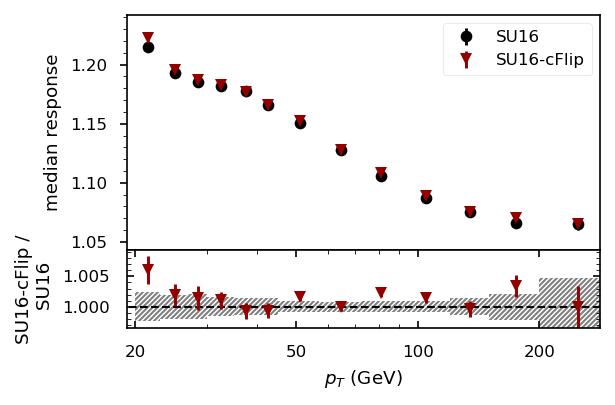

Fitting subsample:  _cbar
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_cbar_eta30to50_L5_SU16-SU16-cFlip-median


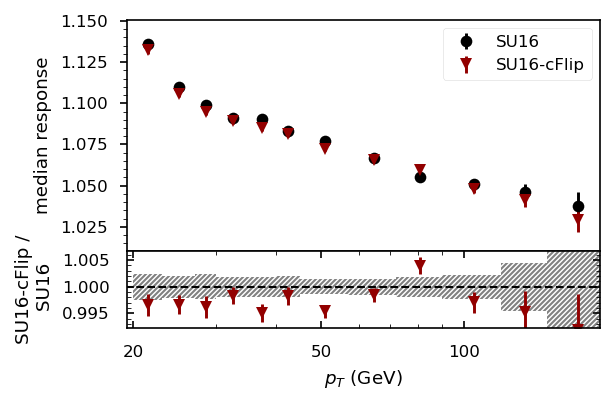

Fitting subsample:  _ubar
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_ubar_eta00to13_L5_SU16-SU16-cFlip-median


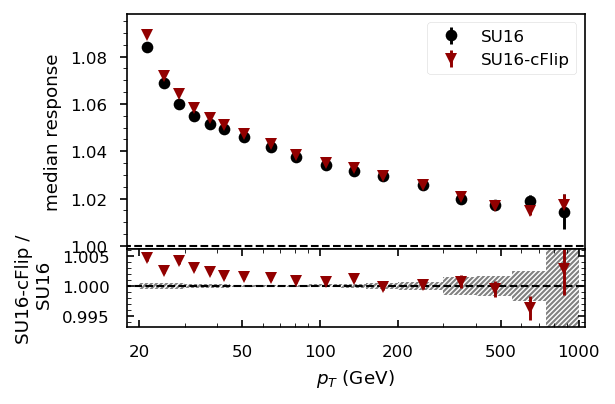

Fitting subsample:  _ubar
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_ubar_eta13to25_L5_SU16-SU16-cFlip-median


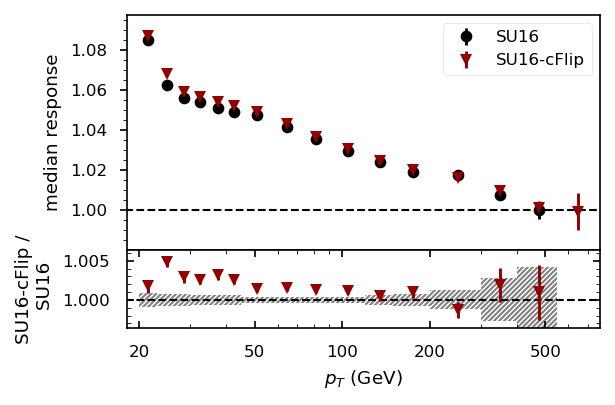

Fitting subsample:  _ubar
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_ubar_eta25to30_L5_SU16-SU16-cFlip-median


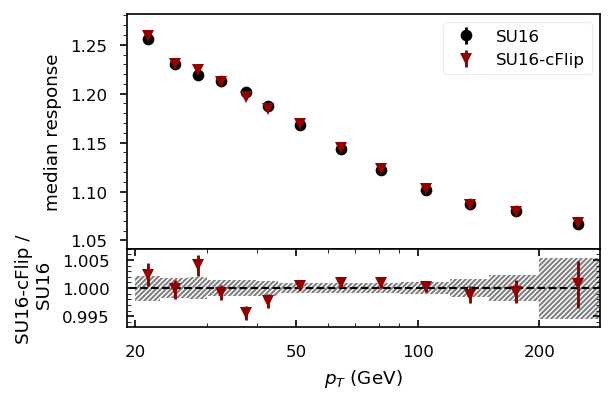

Fitting subsample:  _ubar
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_ubar_eta30to50_L5_SU16-SU16-cFlip-median


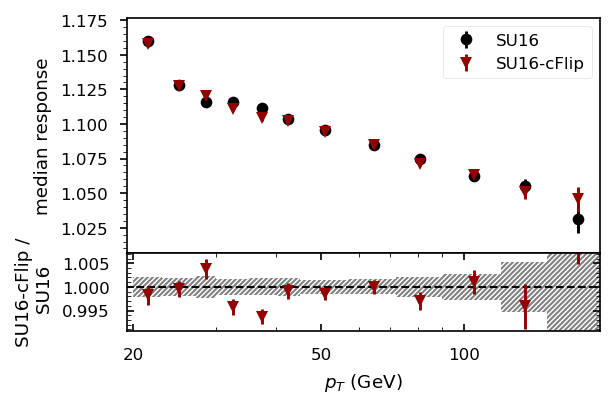

Fitting subsample:  _dbar
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_dbar_eta00to13_L5_SU16-SU16-cFlip-median


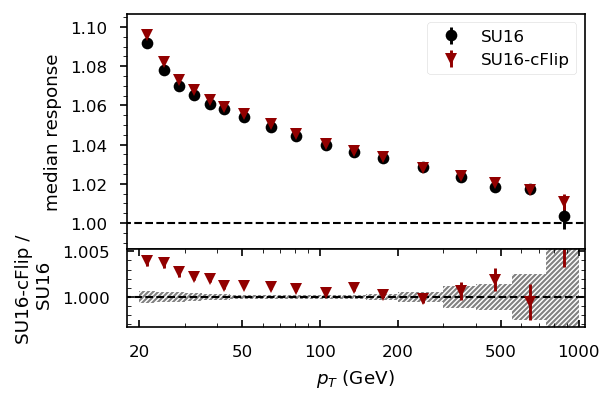

Fitting subsample:  _dbar
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_dbar_eta13to25_L5_SU16-SU16-cFlip-median


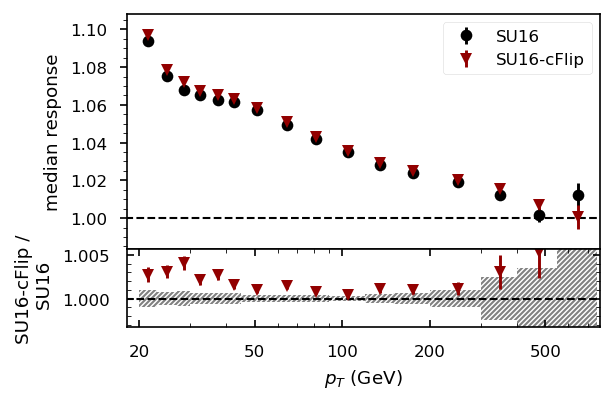

Fitting subsample:  _dbar
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_dbar_eta25to30_L5_SU16-SU16-cFlip-median


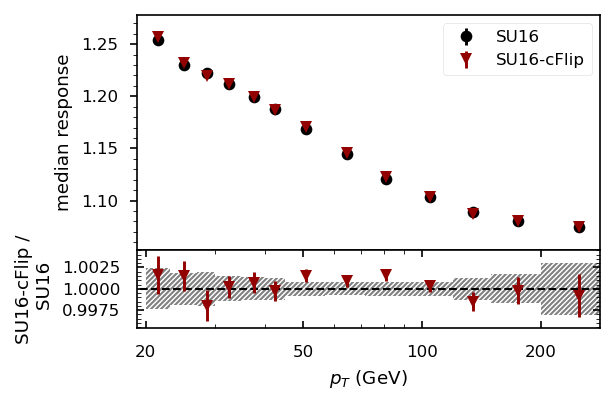

Fitting subsample:  _dbar
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_dbar_eta30to50_L5_SU16-SU16-cFlip-median


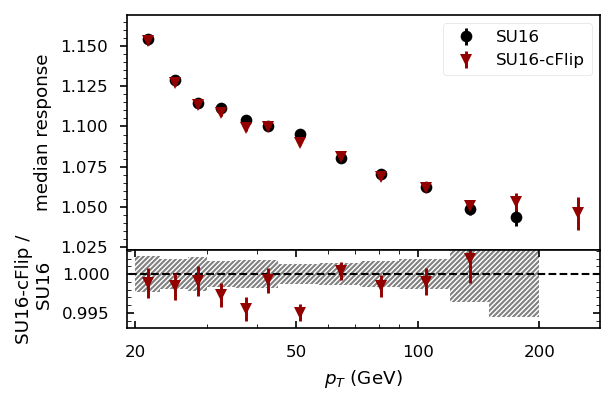

Fitting subsample:  _sbar
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_sbar_eta00to13_L5_SU16-SU16-cFlip-median


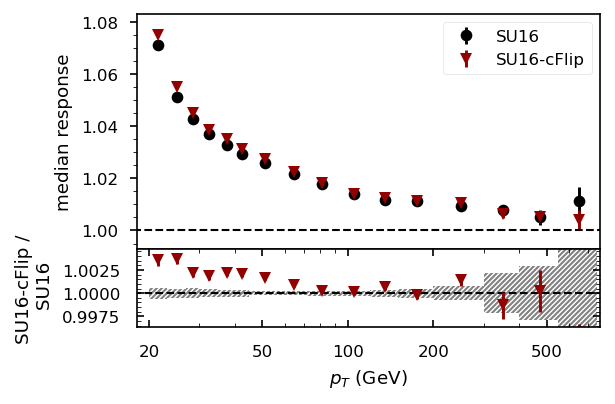

Fitting subsample:  _sbar
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_sbar_eta13to25_L5_SU16-SU16-cFlip-median


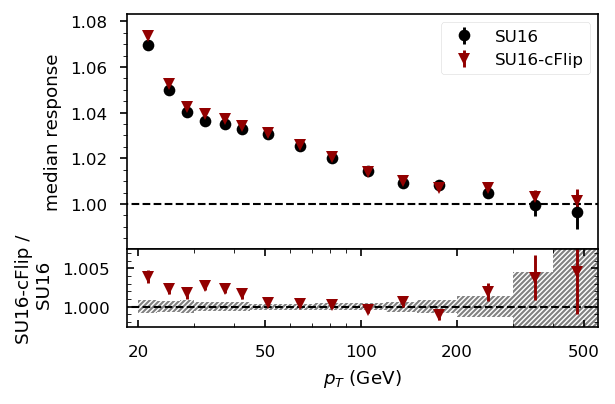

Fitting subsample:  _sbar
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_sbar_eta25to30_L5_SU16-SU16-cFlip-median


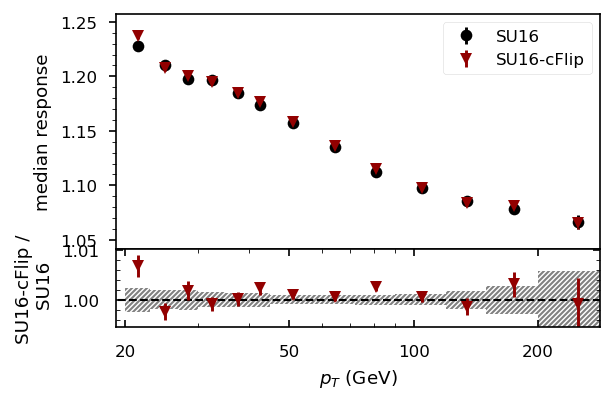

Fitting subsample:  _sbar
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_sbar_eta30to50_L5_SU16-SU16-cFlip-median


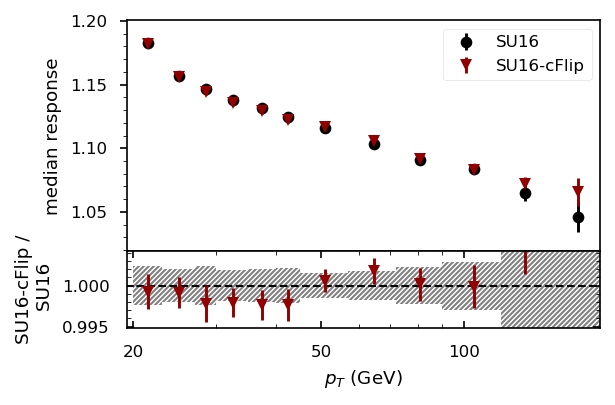

Fitting subsample:  
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_eta00to13_L5_SU16-SU16-cFlip-median


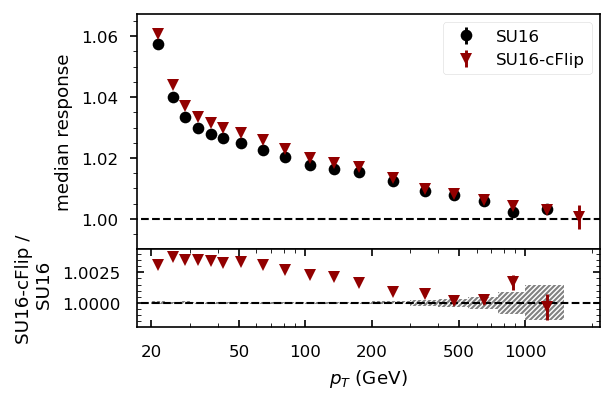

Fitting subsample:  
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_eta13to25_L5_SU16-SU16-cFlip-median


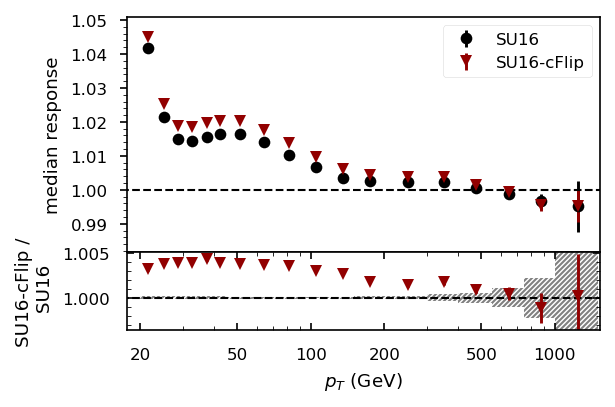

Fitting subsample:  
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_eta25to30_L5_SU16-SU16-cFlip-median


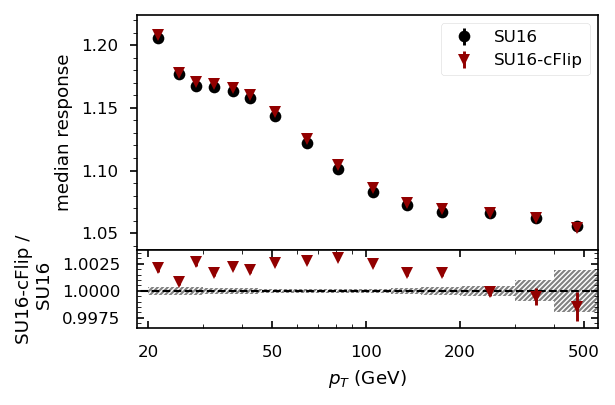

Fitting subsample:  
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_eta30to50_L5_SU16-SU16-cFlip-median


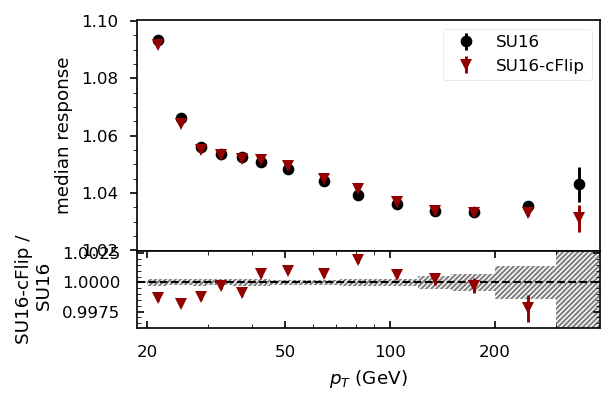

In [20]:
# load_fit_res=True
subsamples = ['_b', '_c', '_d', '_u', '_s', '_g', '_bbar', '_cbar', '_ubar', '_dbar', '_sbar', '']
# subsamples = ['']

k2 = np.where(etabins_mod<=0)[0][-1]
k4 = np.where(etabins_mod<=1.3)[0][-1]
k6 = np.where(etabins_mod<=2.5)[0][-1]
k8 = np.where(etabins_mod<=3.0)[0][-1]
ks = [k2, k4, k6, k8]
# ks = [k2]

# ks = [k2, k4] #, k6, k8]
# subsamples = [''] #, '_b']
for samp in subsamples:
    for k in ks:
        print('Fitting subsample: ', samp)
        print('Eta: ', k)
#         median_QCD = read_data("Median", samp, '_L5_LHEflav1_TTBAR-JME')
#         medianstd_QCD = read_data("MedianStd", samp, '_L5_LHEflav1_TTBAR-JME')
#         median_TTBAR = read_data("Median", samp, '_L5_LHEflav1_Herwig-TTBAR-JME')
#         medianstd_TTBAR = read_data("MedianStd", samp, '_L5_LHEflav1_Herwig-TTBAR-JME')

        median_QCD = read_data("Median", samp, '_L5_LHEflav1_TTBAR-Summer16')
        medianstd_QCD = read_data("MedianStd", samp, '_L5_LHEflav1_TTBAR-Summer16')
        median_TTBAR = read_data("Median", samp, '_L5_LHEflav1_TTBAR-Summer16-cFlip')
        medianstd_TTBAR = read_data("MedianStd", samp, '_L5_LHEflav1_TTBAR-Summer16-cFlip')
        
        
        make_comparison_plot(median_QCD, medianstd_QCD, median_TTBAR, medianstd_TTBAR,
                             k, samp, "SU16", "SU16-cFlip")
        
3;

Fitting subsample:  _b
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_b_eta00to13_L5_b-bbar-median


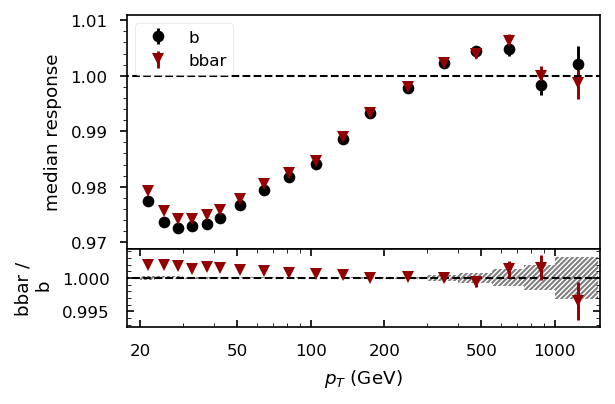

Fitting subsample:  _b
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_b_eta13to25_L5_b-bbar-median


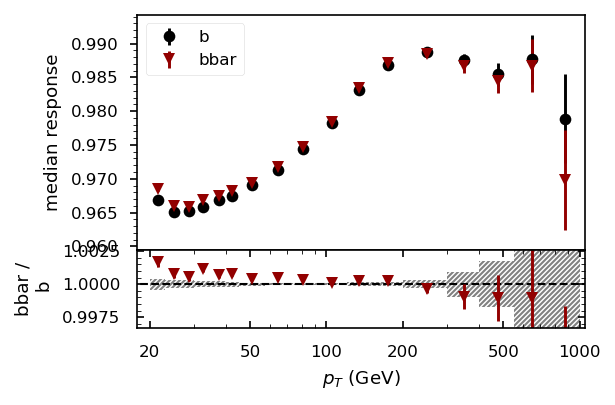

Fitting subsample:  _b
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_b_eta25to30_L5_b-bbar-median


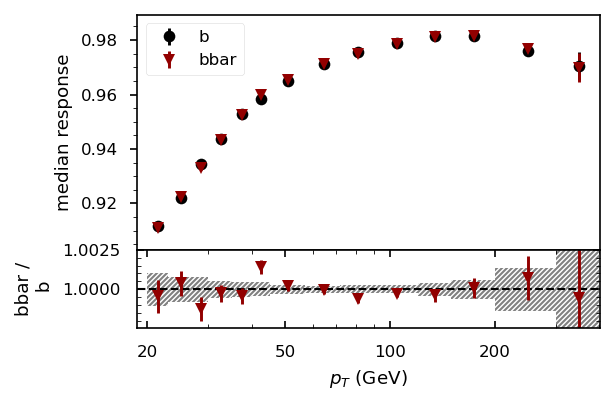

Fitting subsample:  _b
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_b_eta30to50_L5_b-bbar-median


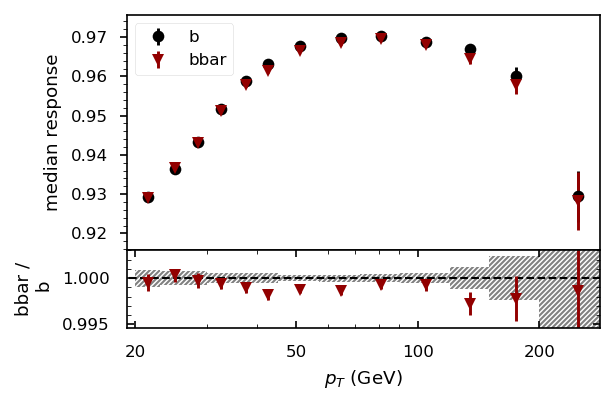

Fitting subsample:  _c
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_c_eta00to13_L5_c-cbar-median


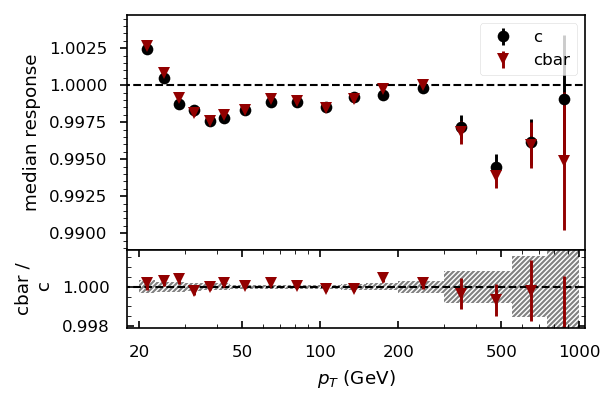

Fitting subsample:  _c
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_c_eta13to25_L5_c-cbar-median


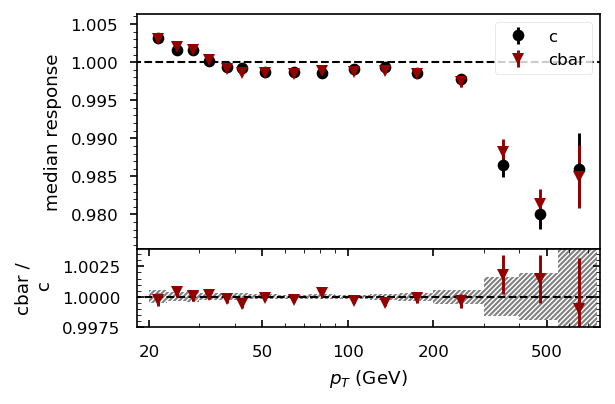

Fitting subsample:  _c
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_c_eta25to30_L5_c-cbar-median


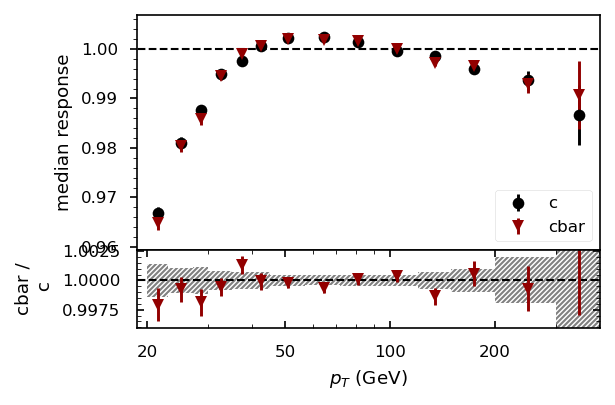

Fitting subsample:  _c
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_c_eta30to50_L5_c-cbar-median


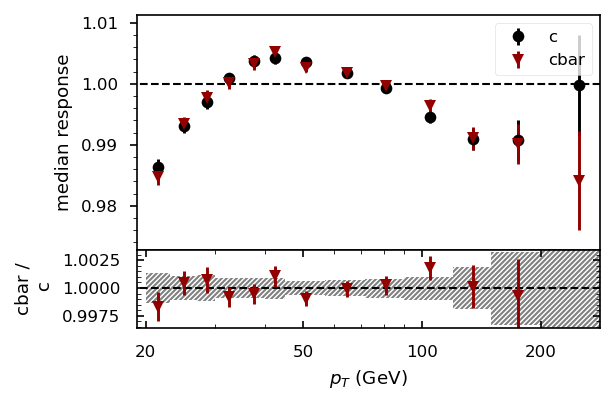

Fitting subsample:  _ud
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_ud_eta00to13_L5_ud-udbar-median


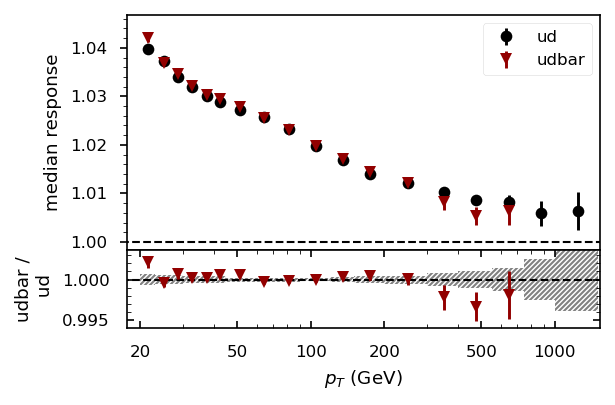

Fitting subsample:  _ud
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_ud_eta13to25_L5_ud-udbar-median


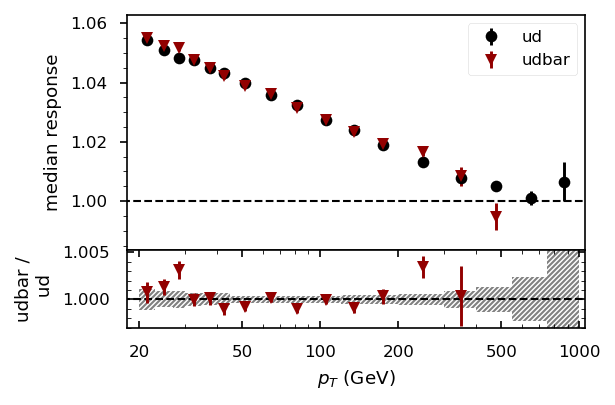

Fitting subsample:  _ud
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_ud_eta25to30_L5_ud-udbar-median


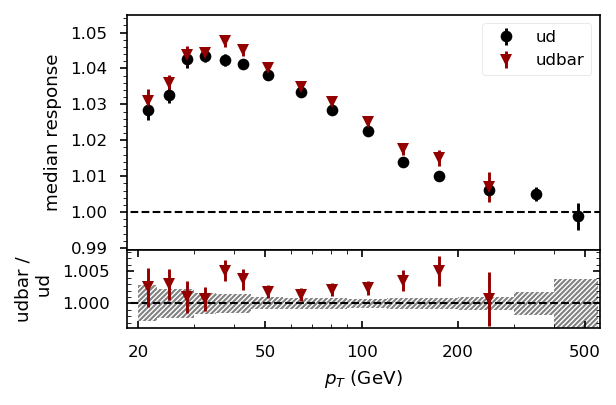

Fitting subsample:  _ud
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_ud_eta30to50_L5_ud-udbar-median


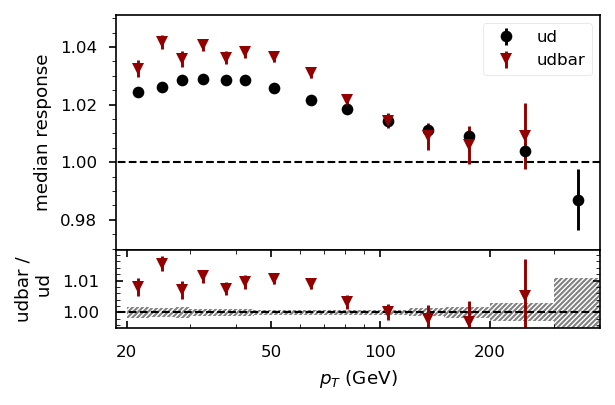

Fitting subsample:  _s
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_s_eta00to13_L5_s-sbar-median


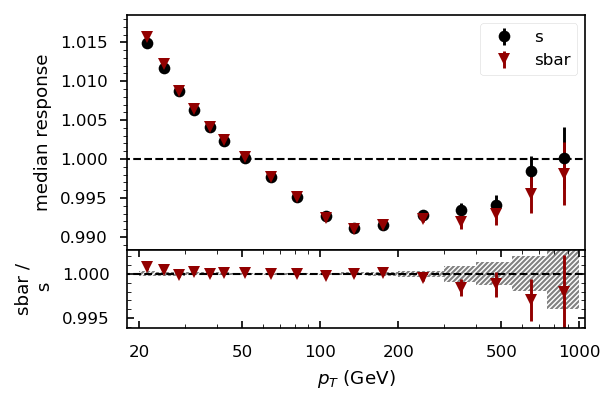

Fitting subsample:  _s
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_s_eta13to25_L5_s-sbar-median


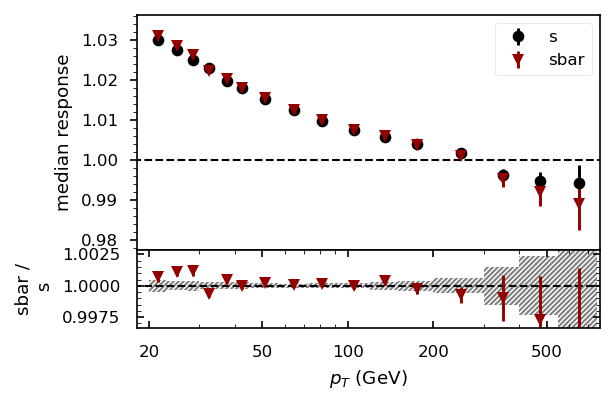

Fitting subsample:  _s
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_s_eta25to30_L5_s-sbar-median


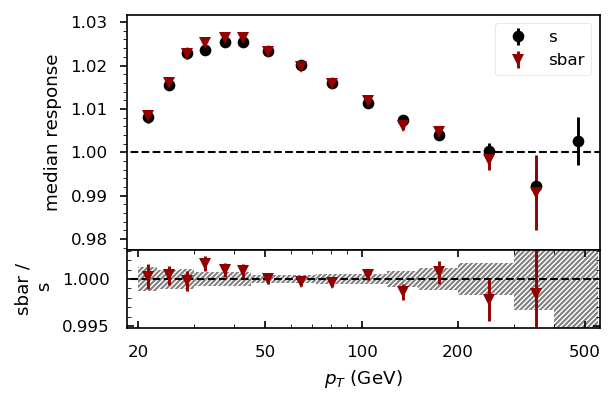

Fitting subsample:  _s
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_s_eta30to50_L5_s-sbar-median


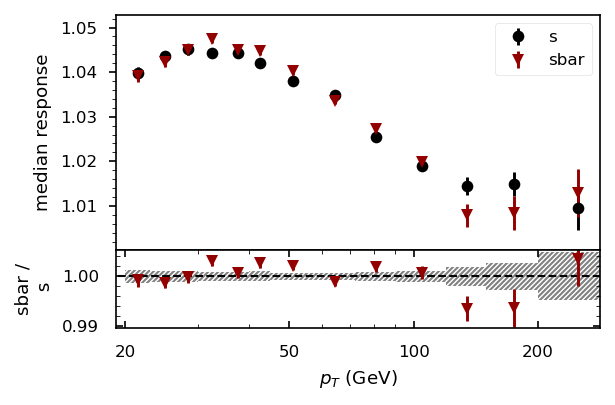

In [10]:
# load_fit_res=True
# subsamples = ['_b', '_c', '_ud', '_s', '_g', '_bbar', '_cbar', '_udbar', '_sbar']
subsamples = ['_b', '_c', '_ud', '_s']

k2 = np.where(etabins_mod<=0)[0][-1]
k4 = np.where(etabins_mod<=1.3)[0][-1]
k6 = np.where(etabins_mod<=2.5)[0][-1]
k8 = np.where(etabins_mod<=3.0)[0][-1]
ks = [k2, k4, k6, k8]
# ks = [k2]

# ks = [k2, k4] #, k6, k8]
# subsamples = [''] #, '_b']
for samp in subsamples:
    for k in ks:
        print('Fitting subsample: ', samp)
        print('Eta: ', k)
        median_QCD = read_data("Median", samp, '_L5_LHEflav1_Herwig-TTBAR-JME')
        medianstd_QCD = read_data("MedianStd", samp, '_L5_LHEflav1_Herwig-TTBAR-JME')
        median_TTBAR = read_data("Median", samp+'bar', '_L5_LHEflav1_Herwig-TTBAR-JME')
        medianstd_TTBAR = read_data("MedianStd", samp+'bar', '_L5_LHEflav1_Herwig-TTBAR-JME')
        
        
        make_comparison_plot(median_QCD, medianstd_QCD, median_TTBAR, medianstd_TTBAR,
                             k, samp, samp[1:], samp[1:]+"bar")
        
3;

In [10]:
# # load_fit_res=True
# subsamples = ['', '_b', '_c', '_s', '_ud', '_g']

# k2 = np.where(etabins_mod<=0)[0][-1]
# k4 = np.where(etabins_mod<=1.3)[0][-1]
# k6 = np.where(etabins_mod<=2.5)[0][-1]
# k8 = np.where(etabins_mod<=3.0)[0][-1]
# ks = [k2, k4, k6, k8]

# # ks = [k2, k4] #, k6, k8]
# # subsamples = [''] #, '_b']
# for samp in subsamples:
#     for k in ks:
#         print('Fitting subsample: ', samp)
#         print('Eta: ', k)
#         median_QCD = read_data("Median", samp, '_L5_LHEflav_TTBAR-JME')
#         medianstd_QCD = read_data("MedianStd", samp, '_L5_LHEflav_TTBAR-JME')
#         median_TTBAR = read_data("Median", samp, '_L5_LHEflav1_TTBAR-JME')
#         medianstd_TTBAR = read_data("MedianStd", samp, '_L5_LHEflav1_TTBAR-JME')
        
        
#         make_comparison_plot(median_QCD, medianstd_QCD, median_TTBAR, medianstd_TTBAR,
#                              k, samp, 'TTBAR, LHEflav2', 'TTBAR, LHEflav1')
        
# 3;

In [56]:
# def make_comparison_plot_three(yvar1, std1, yvar2, std2, yvar3, std3, k, samp,
#                                name1:str, name2:str, name3:str, ratio_name:str):
#     ''' Make a coparison and a ratio plot of yvar2 vs yvar1
#     '''
    
#     mean_p_base = yvar1.copy()
#     mean_p_base[(mean_p_base==0) | (np.abs(mean_p_base)==np.inf)] = np.nan
    
#     mean_p_2 = yvar2.copy()
#     mean_p_2[(mean_p_2==0) | (np.abs(mean_p_2)==np.inf)] = np.nan
    
#     mean_p_3 = yvar3.copy()
#     mean_p_3[(mean_p_3==0) | (np.abs(mean_p_3)==np.inf)] = np.nan

#     fig = plt.figure()
#     gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0, height_ratios=[3, 1])
#     ax = fig.add_subplot(gs[0])
#     ax2 = fig.add_subplot(gs[1])
#     start = np.where(ptbins<=20)[0][-1]

#     for axis in [ax.xaxis, ax.yaxis, ax2.xaxis, ax2.yaxis]:
#         axis.set_minor_locator(mpl.ticker.AutoMinorLocator())

#     xvals = (ptbins[start:-1] + ptbins[start+1:])/2
#     wd = np.abs(ptbins[start:-1] - ptbins[start+1:])
#     vals_base = mean_p_base[start:,k]
#     vals_2 = mean_p_2[start:,k]
#     vals_3 = mean_p_3[start:,k]

# #     print(xvals)
# #     print(vals_base)
#     p1 = ax.errorbar(xvals, vals_base, yerr=std1[start:,k], marker='o',
# #                      markerfacecolor='none', markeredgewidth=1,
#                  linestyle="none", label=name1, color='k')

#     p5 = ax.errorbar(xvals, vals_2, yerr=std2[start:,k], marker='v',
# #                      markerfacecolor='none', markeredgewidth=1, color=p1.lines[0].get_color(),
#                  linestyle="none", label=name2)
    
#     p5 = ax.errorbar(xvals, vals_3, yerr=std3[start:,k], marker='^',
# #                      markerfacecolor='none', markeredgewidth=1, color=p1.lines[0].get_color(),
#                  linestyle="none", label=name3)

#     ax2.hlines(1,1, 10000, linestyles='--',color="black",
#         linewidth=1,)
#     rel_mc_unc =  std1[start:,k]/vals_base 

#     ax2.bar(
#         xvals,
#         2 * rel_mc_unc,
#         width=wd,
#         bottom=1.0 - rel_mc_unc,
#         fill=False,
#         linewidth=0,
#         edgecolor="gray",
#         hatch=10 * "/",
#     )


#     # data in ratio plot
#     data_model_ratio = vals_2/vals_base
#     data_model_ratio_unc = std2[start:,k] / vals_base
# #     print(vals_2)
# #     print(vals_base)
# #     print(data_model_ratio)
#     # mask data in bins where total model yield is 0
#     ax2.errorbar(
#         xvals,
#         data_model_ratio, #[nonzero_model_yield],
#         yerr=data_model_ratio_unc, #[nonzero_model_yield],
#         fmt="v",
# #         color="k",
#     )
    
#     # data in ratio plot 2
#     data_model_ratio_2 = vals_3/vals_base
#     data_model_ratio_unc_2 = std3[start:,k] / vals_base
#     # mask data in bins where total model yield is 0
#     ax2.errorbar(
#         xvals,
#         data_model_ratio_2, #[nonzero_model_yield],
#         yerr=data_model_ratio_unc_2, #[nonzero_model_yield],
#         fmt="^",
# #         color="k",
#     )


#     ax2.set_ylabel(ratio_name)
#     ax2.tick_params(axis="both", which="major", pad=8)
#     ax2.tick_params(direction="in", top=True, right=True, which="both")

#     fig.set_tight_layout(True)

#     ### Calculate resonable limits excluding the few points with insane errors
#     yerr_norm = np.concatenate([std1[start:,k], std2[start:,k], std3[start:,k] ])
#     y_norm = np.concatenate([vals_base, vals_2, vals_3])
#     norm_pos = (yerr_norm<0.04) &  (yerr_norm != np.inf) & (y_norm>-0.1)
#     ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))

#     yerr_norm = np.concatenate([std1[start:,k]/vals_base, std2[start:,k]/vals_base, std3[start:,k]/vals_base ])
#     y_norm = np.concatenate([vals_base/vals_base, data_model_ratio, data_model_ratio_2])
#     norm_pos = (yerr_norm<0.008) &  (yerr_norm != np.inf) & (y_norm>-0.1)  
# #     if samp == '_b' and k==3:
# #         1/0
#     left_lim = np.min((y_norm-yerr_norm)[norm_pos])
#     right_lim = np.max((yerr_norm+y_norm)[norm_pos])
#     lim_pad = (right_lim - left_lim)/10
#     ax2.set_ylim(left_lim-lim_pad, right_lim+lim_pad)

#     ax2.set_xlabel(r'$p_T$ (GeV)');
#     ax.set_ylabel(r'median response');
#     ax.set_xscale('log')
#     ax2.set_xscale('log')

#     ax.set_xticks([])
#     ax2.set_xticks([20, 50, 100, 500, 1000, 5000])
#     ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#     leg1 = ax.legend()

#     ax2.set_xlim(ax.get_xlim())
#     eta_string = '_eta'+str(etabins_mod[k])+'to'+str(etabins_mod[k+1])
#     eta_string = eta_string.replace('.','')
#     print("Saving plot for eta = ", eta_string)
#     fig_name = 'fig/corr_vs_pt'+samp+eta_string+'_L5_'+name1+'-'+name2+'-'+name3+'-median'
#     fig_name = fig_name.replace(', ', '-')
#     print("Saving plot with the name = ", fig_name)
#     plt.savefig(fig_name+'.pdf');
#     plt.savefig(fig_name+'.png');
#     # gs1.tight_layout(fig, rect=[0, 0.1, 0.8, 0.5])
#     plt.show();

In [19]:
def make_comparison_plot_many(yvar_base, std_base, yvars = np.array([]), stds = np.array([]), k=0, samp='',
                               name_base='', names=[], ratio_name='ratio'):
    ''' Make a coparison and a ratio plot of yvar2 vs yvar_base
    '''
    
    mean_p_base = yvar_base.copy()
    mean_p_base[(mean_p_base==0) | (np.abs(mean_p_base)==np.inf)] = np.nan
    
    # mean_ps = []
    # for yvar in yvars:
    #     mean_ps = yvar.copy()

    yvars[(yvars==0) | (np.abs(yvars)==np.inf)] = np.nan


    fig = plt.figure()
    gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0, height_ratios=[3, 1])
    ax = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    start = np.where(ptbins<=20)[0][-1]

    for axis in [ax.xaxis, ax.yaxis, ax2.xaxis, ax2.yaxis]:
        axis.set_minor_locator(mpl.ticker.AutoMinorLocator())

    xvals = (ptbins[start:-1] + ptbins[start+1:])/2
    wd = np.abs(ptbins[start:-1] - ptbins[start+1:])
    vals_base = mean_p_base[start:,k]
    yvars = yvars[:,start:,k]
    std_base = std_base[start:,k]
    stds = stds[:,start:,k]

#     print(xvals)
#     print(vals_base)
    p1 = ax.errorbar(xvals, vals_base, yerr=std_base, marker='o',
#                      markerfacecolor='none', markeredgewidth=1,
                 linestyle="none", label=name_base, color='k')

    markers = ['v','^','d', 'p']
    for val, name, std, marker in zip(yvars, names, stds, markers):
        ax.errorbar(xvals, val, yerr=std, marker=marker,
                    linestyle="none", label=name)
        
    ax2.hlines(1,1, 10000, linestyles='--',color="black",
        linewidth=1,)
    rel_mc_unc =  std_base/vals_base 

    ax2.bar(
        xvals,
        2 * rel_mc_unc,
        width=wd,
        bottom=1.0 - rel_mc_unc,
        fill=False,
        linewidth=0,
        edgecolor="gray",
        hatch=10 * "/",
    )


    # data in ratio plot
    data_model_ratio = yvars/vals_base
    data_model_ratio_unc = stds / vals_base

    for val, std, marker in zip(data_model_ratio, data_model_ratio_unc, markers):
        ax2.errorbar(
            xvals,
            val, #[nonzero_model_yield],
            yerr=std, #[nonzero_model_yield],
            fmt=marker,
        )
    

    ax2.set_ylabel(ratio_name)
    ax2.tick_params(axis="both", which="major", pad=8)
    ax2.tick_params(direction="in", top=True, right=True, which="both")

    fig.set_tight_layout(True)

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([std_base, np.concatenate(stds) ])
    y_norm = np.concatenate([vals_base, np.concatenate(yvars)])
    norm_pos = (yerr_norm<0.04) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))

    yerr_norm = np.concatenate([rel_mc_unc, np.concatenate(data_model_ratio_unc) ])
    y_norm = np.concatenate([vals_base/vals_base, np.concatenate(data_model_ratio)])
    norm_pos = (yerr_norm<0.008) &  (yerr_norm != np.inf) & (y_norm>-0.1)  
#     if samp == '_b' and k==3:
#         1/0
    left_lim = np.min((y_norm-yerr_norm)[norm_pos])
    right_lim = np.max((yerr_norm+y_norm)[norm_pos])
    lim_pad = (right_lim - left_lim)/10
    ax2.set_ylim(left_lim-lim_pad, right_lim+lim_pad)

    ax2.set_xlabel(r'$p_T$ (GeV)');
    ax.set_ylabel(r'median response');
    ax.set_xscale('log')
    ax2.set_xscale('log')

    xlims = ax.get_xlim()
    ax.hlines(1,1, 10000, linestyles='--',color="black",
              linewidth=1,)
    
    ax.set_xticks([])
    ax2.set_xticks([20, 50, 100, 500, 1000, 5000])
    ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    leg1 = ax.legend()

    ax.set_xlim(xlims)
    ax2.set_xlim(xlims)
    
    eta_string = '_eta'+str(etabins_mod[k])+'to'+str(etabins_mod[k+1])
    eta_string = eta_string.replace('.','')
    print("Saving plot for eta = ", eta_string)
    fig_name = 'fig/corr_vs_pt'+samp+eta_string+'_L5_'+name_base+'-'+'-'.join(names)+'-median'
    fig_name = fig_name.replace(', ', '-')
    print("Saving plot with the name = ", fig_name)
#     plt.savefig(fig_name+'.pdf');
#     plt.savefig(fig_name+'.png');
    # gs1.tight_layout(fig, rect=[0, 0.1, 0.8, 0.5])
    plt.show();

Fitting subsample:  
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_eta00to13_L5_TTBAR-DY-QCD-median


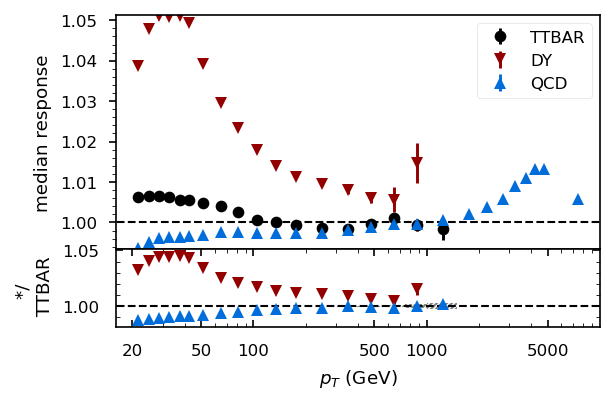

Fitting subsample:  
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_eta13to25_L5_TTBAR-DY-QCD-median


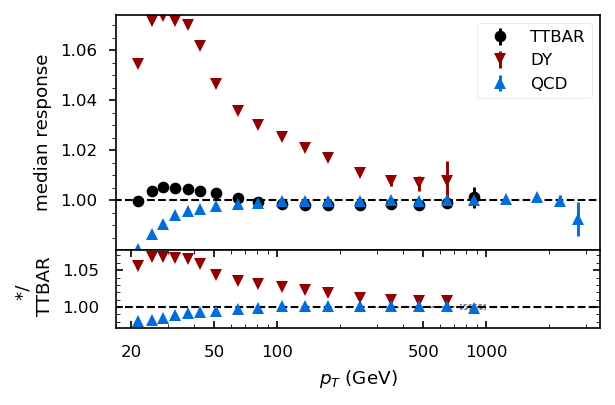

Fitting subsample:  
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_eta25to30_L5_TTBAR-DY-QCD-median


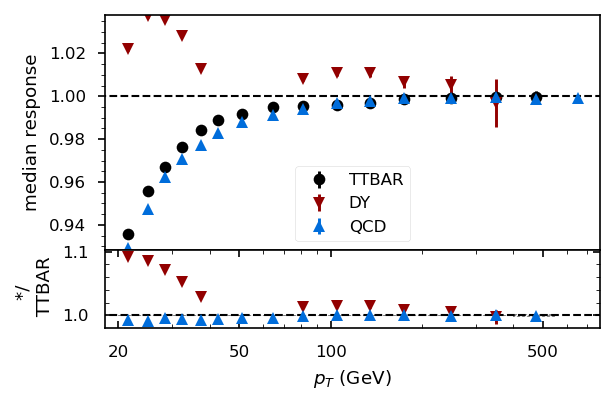

Fitting subsample:  
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_eta30to50_L5_TTBAR-DY-QCD-median


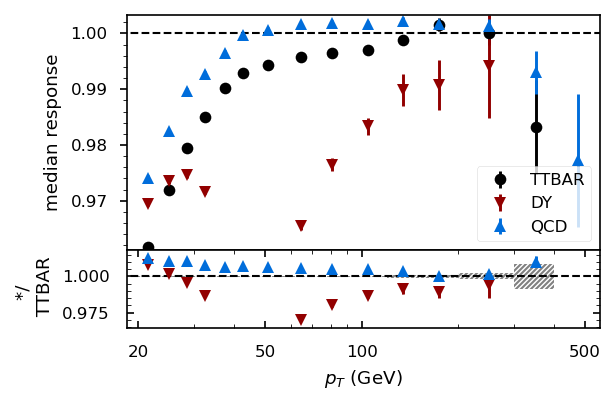

Fitting subsample:  _b
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_b_eta00to13_L5_TTBAR-DY-QCD-median


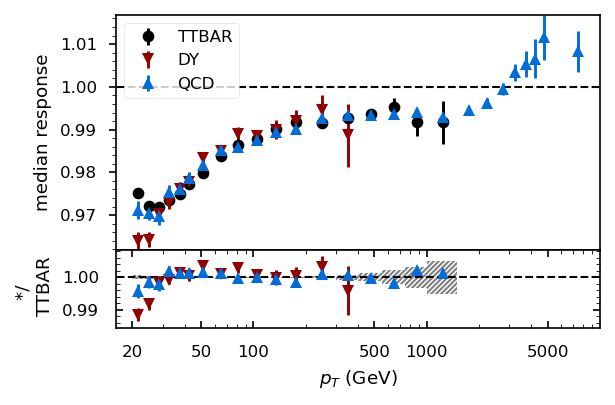

Fitting subsample:  _b
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_b_eta13to25_L5_TTBAR-DY-QCD-median


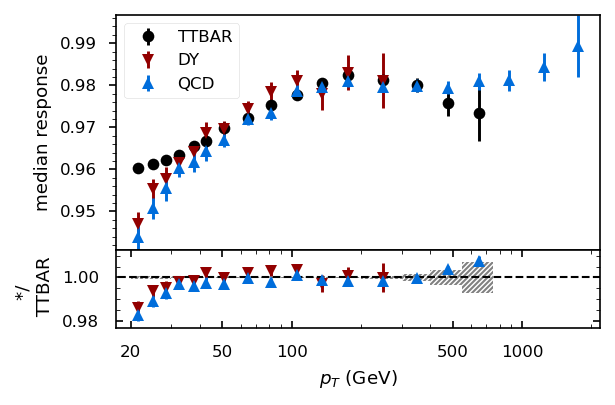

Fitting subsample:  _b
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_b_eta25to30_L5_TTBAR-DY-QCD-median


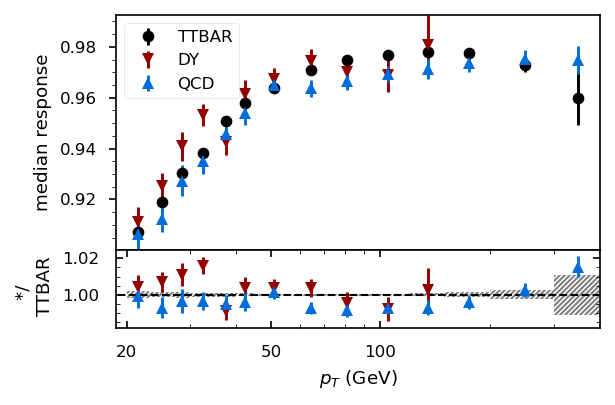

Fitting subsample:  _b
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_b_eta30to50_L5_TTBAR-DY-QCD-median


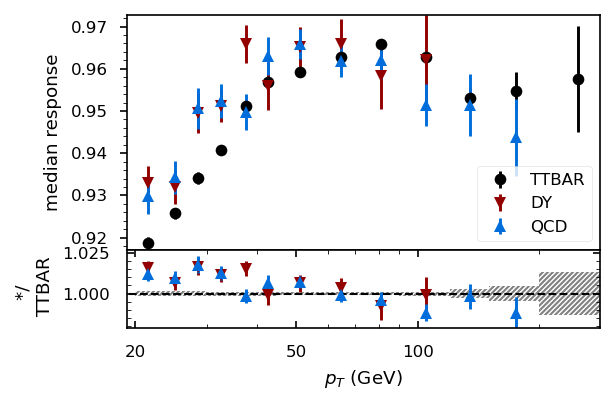

Fitting subsample:  _c
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_c_eta00to13_L5_TTBAR-DY-QCD-median


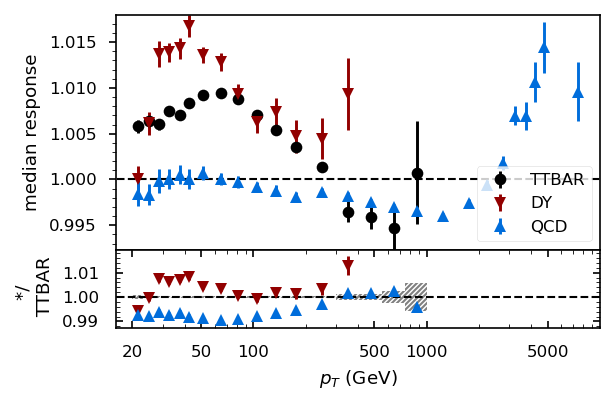

Fitting subsample:  _c
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_c_eta13to25_L5_TTBAR-DY-QCD-median


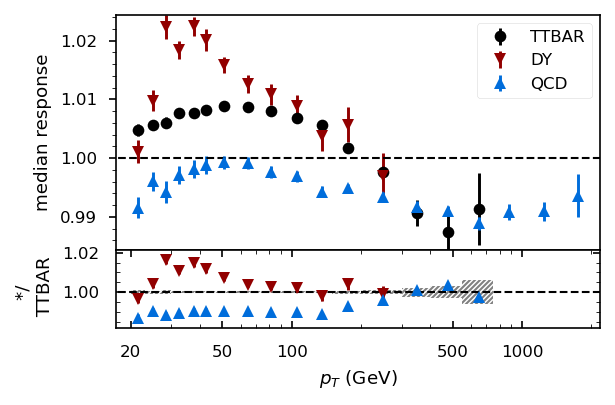

Fitting subsample:  _c
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_c_eta25to30_L5_TTBAR-DY-QCD-median


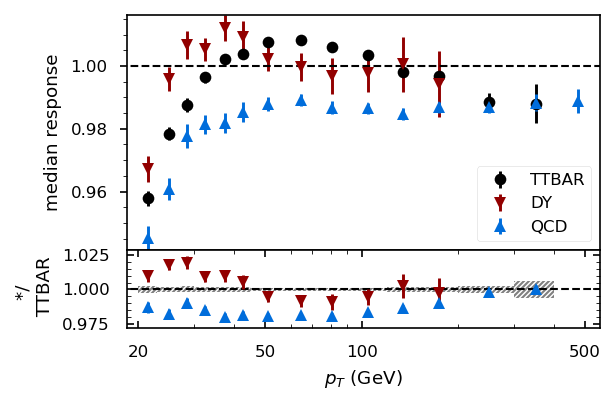

Fitting subsample:  _c
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_c_eta30to50_L5_TTBAR-DY-QCD-median


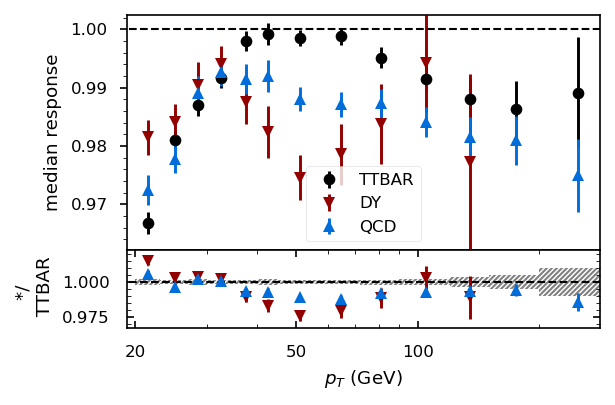

Fitting subsample:  _s
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_s_eta00to13_L5_TTBAR-DY-QCD-median


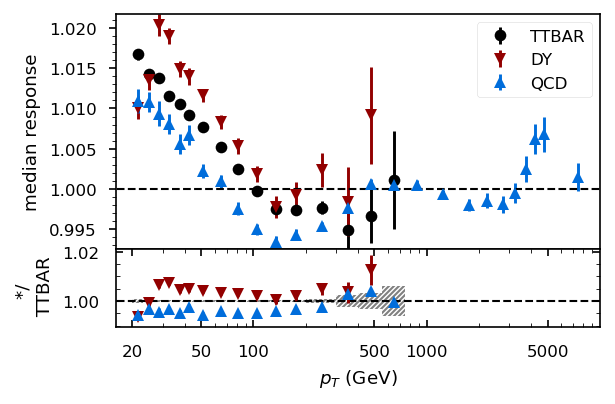

Fitting subsample:  _s
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_s_eta13to25_L5_TTBAR-DY-QCD-median


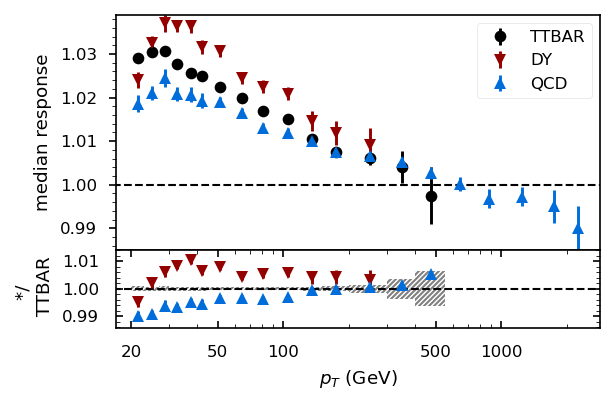

Fitting subsample:  _s
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_s_eta25to30_L5_TTBAR-DY-QCD-median


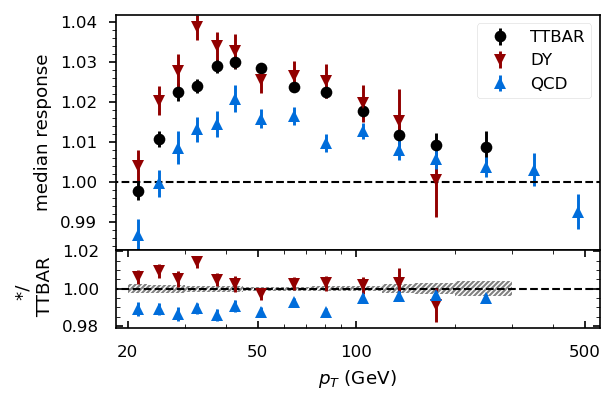

Fitting subsample:  _s
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_s_eta30to50_L5_TTBAR-DY-QCD-median


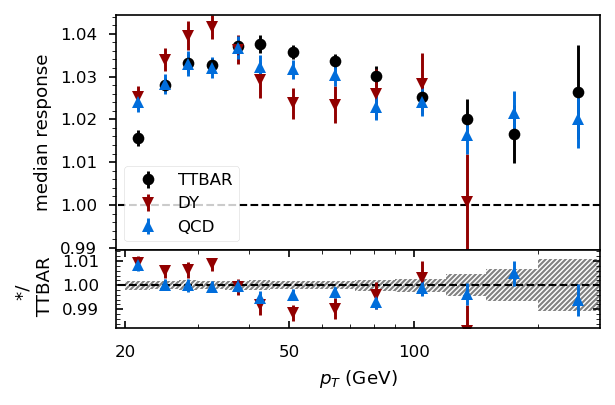

Fitting subsample:  _g
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_g_eta00to13_L5_TTBAR-DY-QCD-median


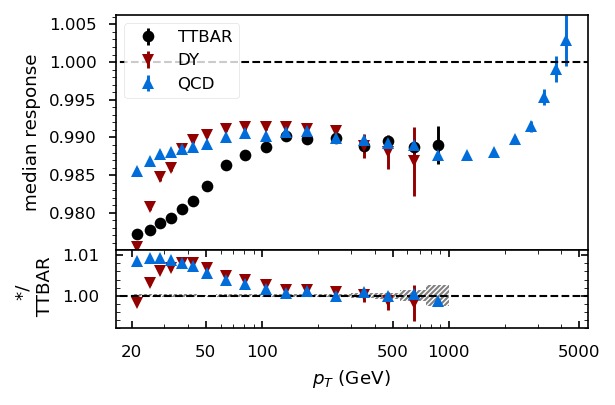

Fitting subsample:  _g
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_g_eta13to25_L5_TTBAR-DY-QCD-median


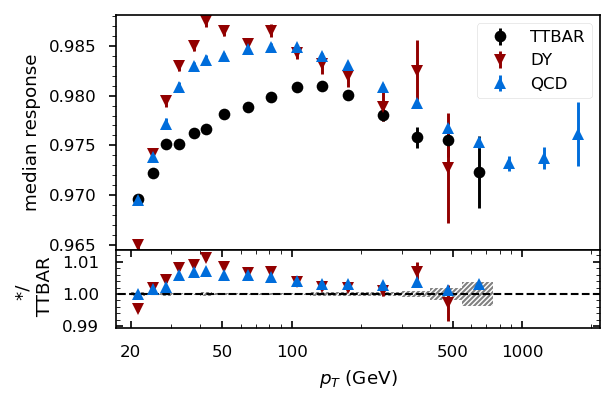

Fitting subsample:  _g
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_g_eta25to30_L5_TTBAR-DY-QCD-median


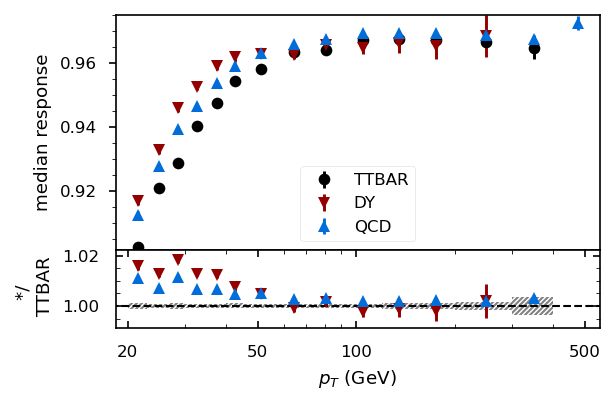

Fitting subsample:  _g
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_g_eta30to50_L5_TTBAR-DY-QCD-median


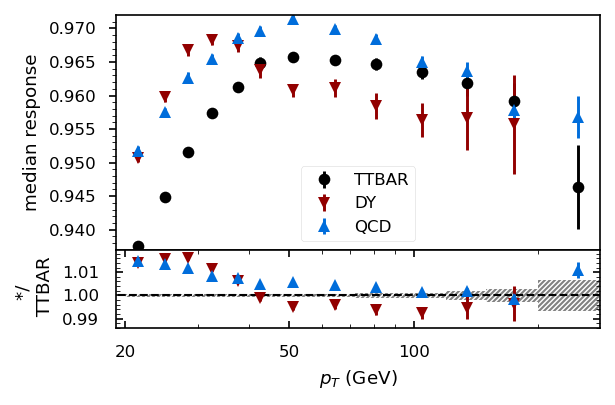

In [22]:
# load_fit_res=True
# subsamples = ['', '_b', '_c', '_s', '_u', '_d', '_g']
subsamples = ['', '_b', '_c', '_s', '_g']
# subsamples = ['_c']
tag1 = '_L5_TTBAR-JME'
tag2 = '_L5_DY-JME'
tag3 = '_L5_QCD-JME'

mean_name = "Median"
mean_name_std = mean_name+'Std'


k2 = np.where(etabins_mod<=0)[0][-1]
k4 = np.where(etabins_mod<=1.3)[0][-1]
k6 = np.where(etabins_mod<=2.5)[0][-1]
k8 = np.where(etabins_mod<=3.0)[0][-1]
ks = [k2, k4, k6, k8]

# ks = [k2, k4] #, k6, k8]
for samp in subsamples:
    for k in ks:
        print('Fitting subsample: ', samp)
        print('Eta: ', k)
        median_QCD = read_data(mean_name, samp, tag1)
        medianstd_QCD = read_data(mean_name_std, samp, tag1)
        median_TTBAR = read_data(mean_name, samp, tag2)
        medianstd_TTBAR = read_data(mean_name_std, samp, tag2)
        median_3 = read_data(mean_name, samp, tag3)
        medianstd_3 = read_data(mean_name_std, samp, tag3)
#         median_4 = read_data("Median", samp, '_L5_LHEflav1_Herwig-TTBAR-JME-noLepIso')
#         medianstd_4 = read_data("MedianStd", samp, '_L5_LHEflav1_Herwig-TTBAR-JME-noLepIso')
        
        
        make_comparison_plot_many(median_QCD, medianstd_QCD,
                                  np.array([median_TTBAR, median_3]), #, median_4]),
                                  np.array([medianstd_TTBAR, medianstd_3]), #, medianstd_4]),
                             k, samp, 'TTBAR', ['DY', 'QCD'], '*/ \n TTBAR')
        
3;

Fitting subsample:  
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


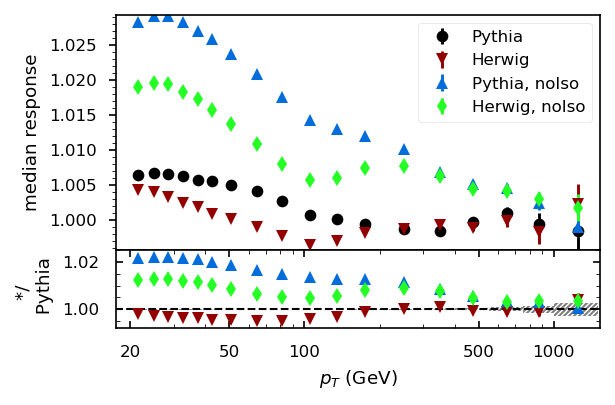

Fitting subsample:  
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


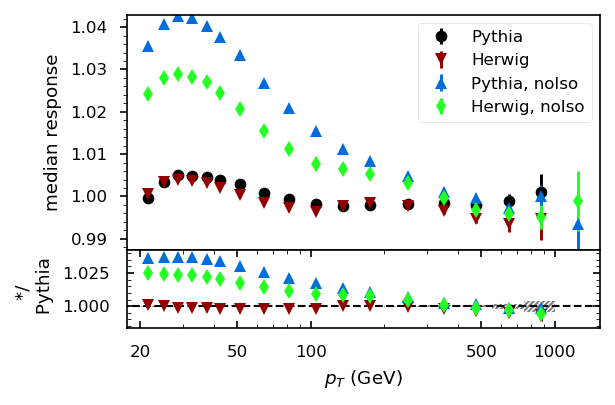

Fitting subsample:  
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


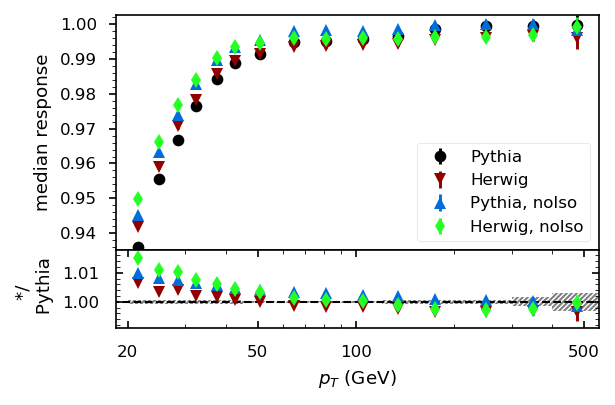

Fitting subsample:  
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


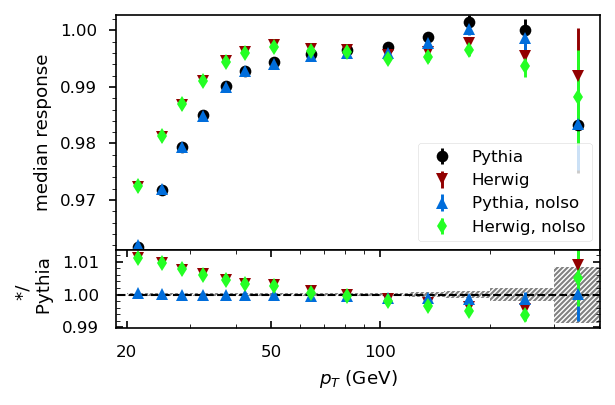

Fitting subsample:  _b
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_b_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


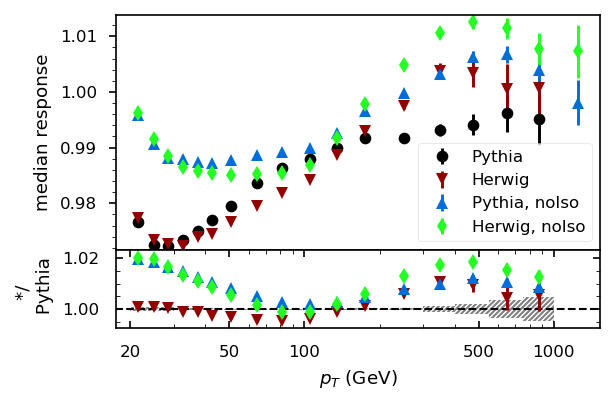

Fitting subsample:  _b
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_b_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


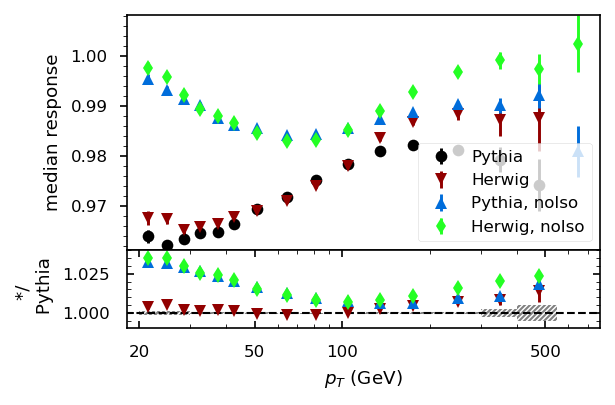

Fitting subsample:  _b
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_b_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


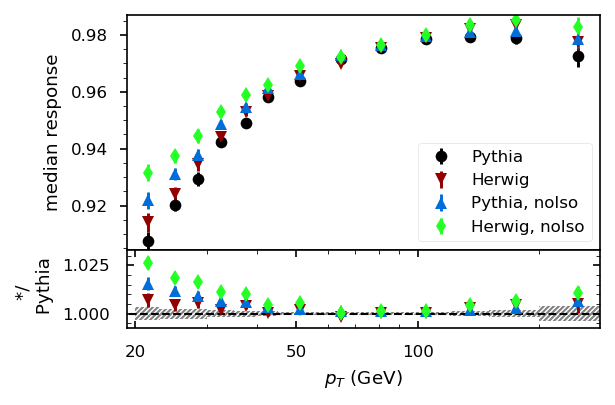

Fitting subsample:  _b
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_b_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


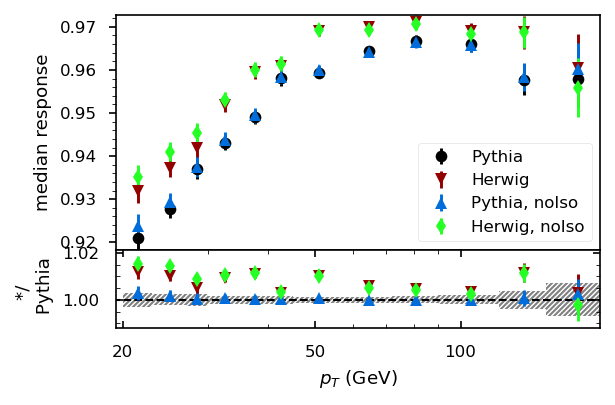

Fitting subsample:  _c
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_c_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


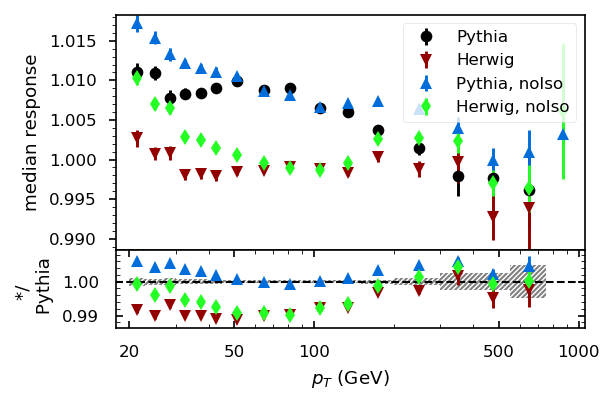

Fitting subsample:  _c
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_c_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


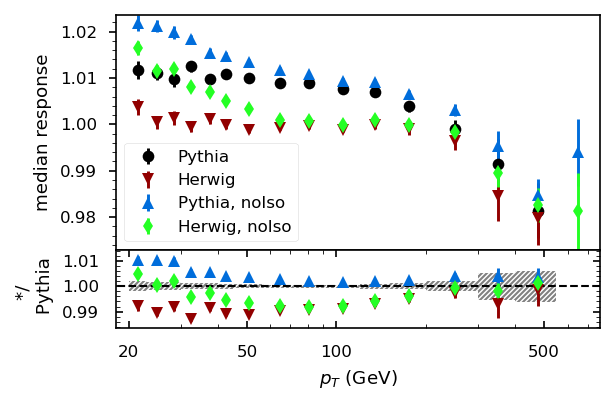

Fitting subsample:  _c
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_c_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


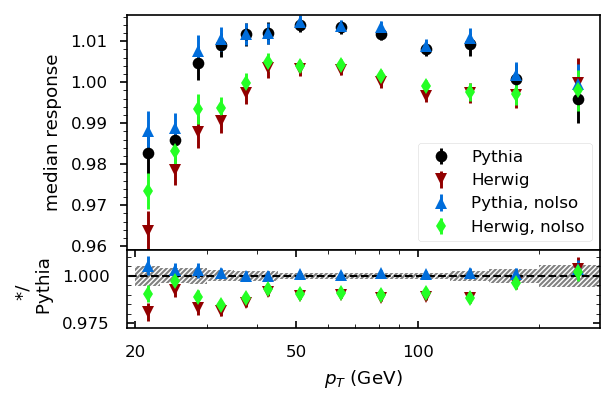

Fitting subsample:  _c
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_c_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


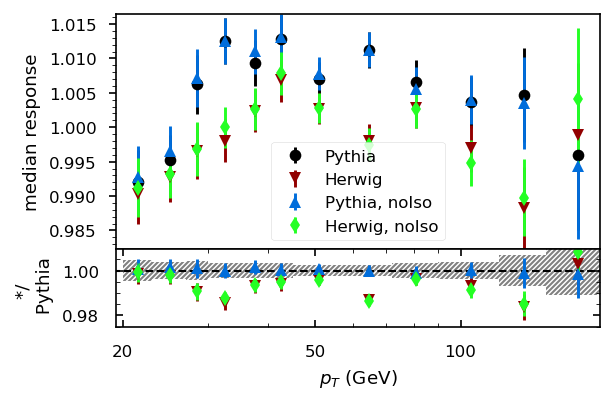

Fitting subsample:  _s
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_s_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


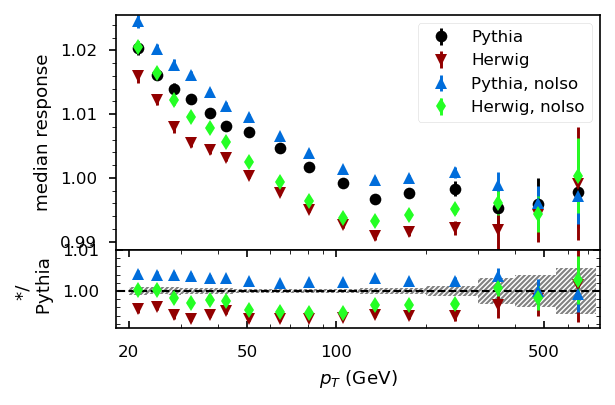

Fitting subsample:  _s
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_s_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


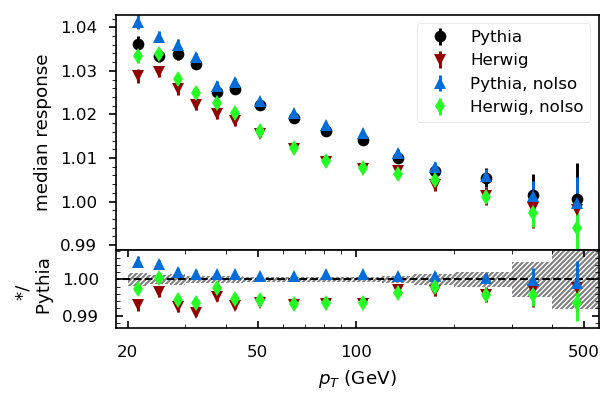

Fitting subsample:  _s
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_s_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


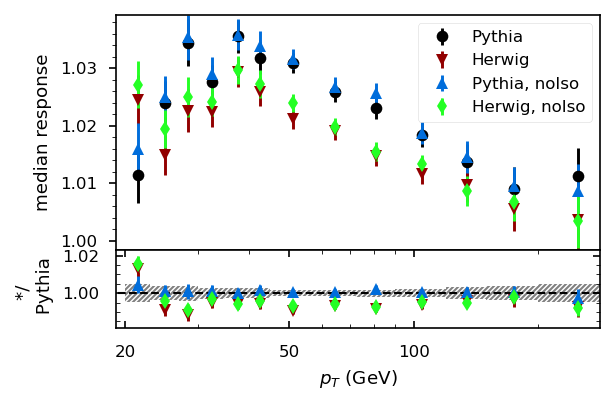

Fitting subsample:  _s
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_s_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


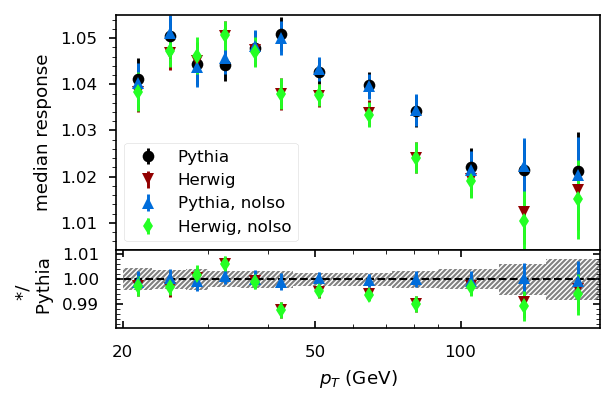

Fitting subsample:  _ud
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_ud_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


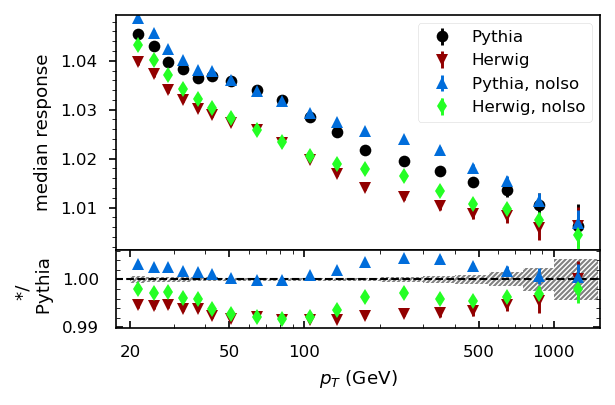

Fitting subsample:  _ud
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_ud_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


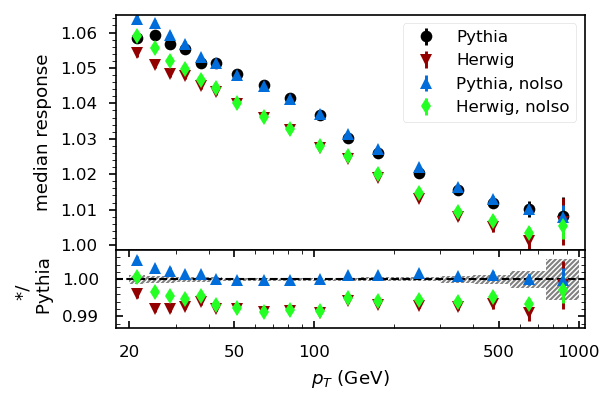

Fitting subsample:  _ud
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_ud_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


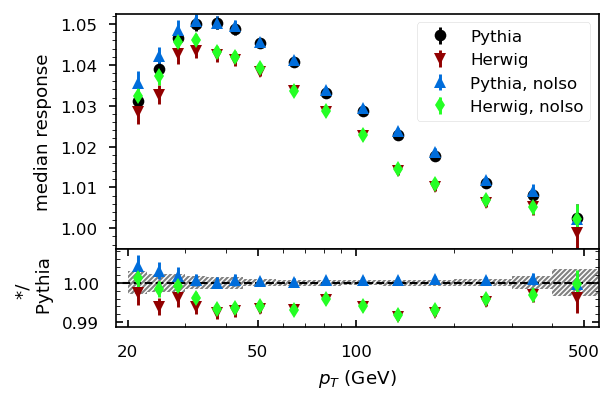

Fitting subsample:  _ud
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_ud_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


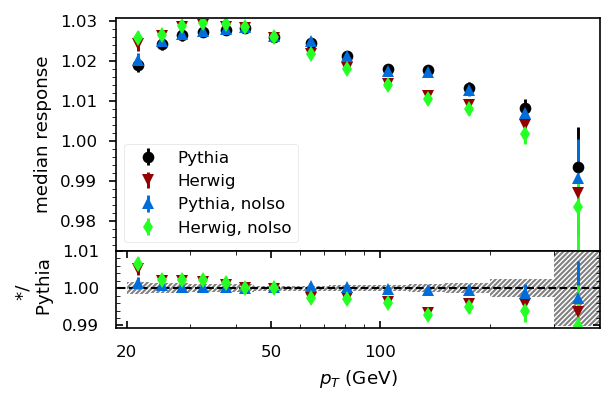

Fitting subsample:  _g
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_g_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


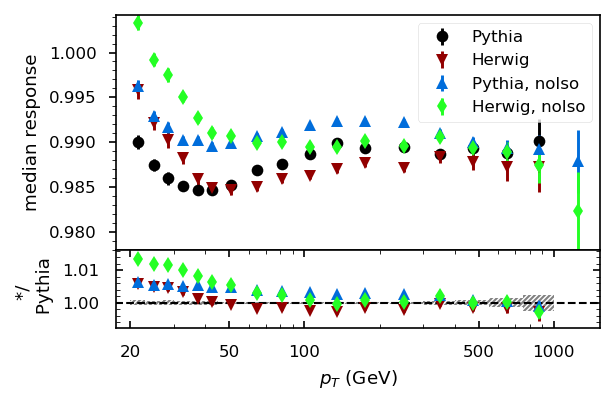

Fitting subsample:  _g
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_g_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


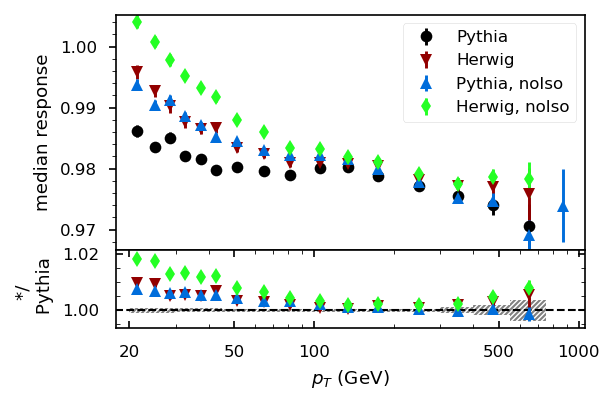

Fitting subsample:  _g
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_g_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


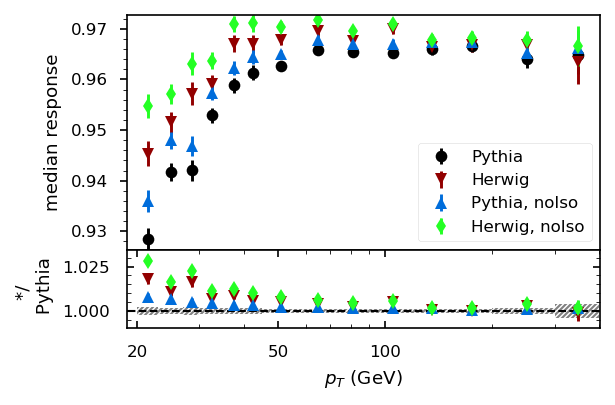

Fitting subsample:  _g
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_g_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


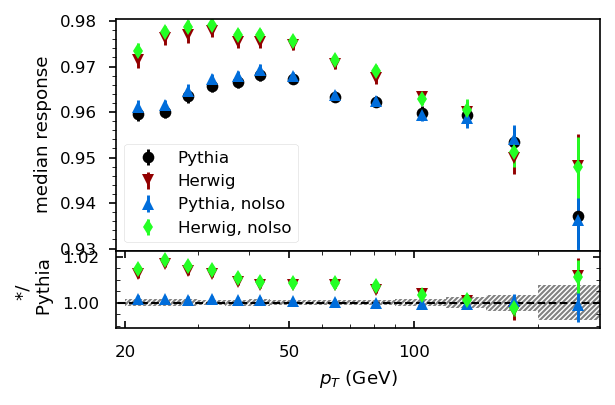

In [22]:
# load_fit_res=True
subsamples = ['', '_b', '_c', '_s', '_ud', '_g']
# subsamples = ['_g']


k2 = np.where(etabins_mod<=0)[0][-1]
k4 = np.where(etabins_mod<=1.3)[0][-1]
k6 = np.where(etabins_mod<=2.5)[0][-1]
k8 = np.where(etabins_mod<=3.0)[0][-1]
ks = [k2, k4, k6, k8]

# ks = [k2, k4] #, k6, k8]
for samp in subsamples:
    for k in ks:
        print('Fitting subsample: ', samp)
        print('Eta: ', k)
        median_QCD = read_data("Median", samp, '_L5_LHEflav1_TTBAR-JME')
        medianstd_QCD = read_data("MedianStd", samp, '_L5_LHEflav1_TTBAR-JME')
        median_TTBAR = read_data("Median", samp, '_L5_LHEflav1_Herwig-TTBAR-JME')
        medianstd_TTBAR = read_data("MedianStd", samp, '_L5_LHEflav1_Herwig-TTBAR-JME')
        median_3 = read_data("Median", samp, '_L5_LHEflav1_TTBAR-JME-noLepIso')
        medianstd_3 = read_data("MedianStd", samp, '_L5_LHEflav1_TTBAR-JME-noLepIso')
        median_4 = read_data("Median", samp, '_L5_LHEflav1_Herwig-TTBAR-JME-noLepIso')
        medianstd_4 = read_data("MedianStd", samp, '_L5_LHEflav1_Herwig-TTBAR-JME-noLepIso')
        
        
        make_comparison_plot_many(median_QCD, medianstd_QCD,
                                  np.array([median_TTBAR, median_3, median_4]),
                                  np.array([medianstd_TTBAR, medianstd_3, medianstd_4]),
                             k, samp, 'Pythia', ['Herwig', 'Pythia, noIso', 'Herwig, noIso'], '*/ \n Pythia')
        
3;

Fitting subsample:  
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


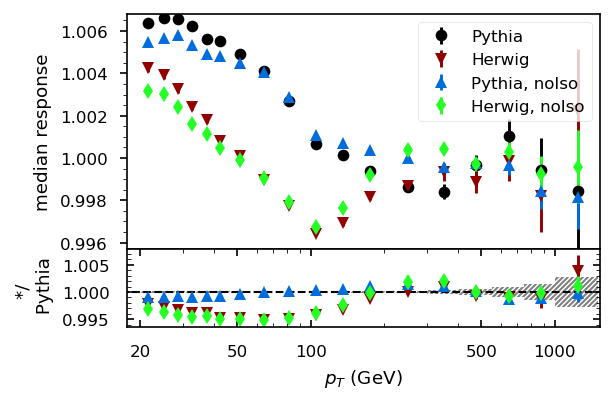

Fitting subsample:  
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


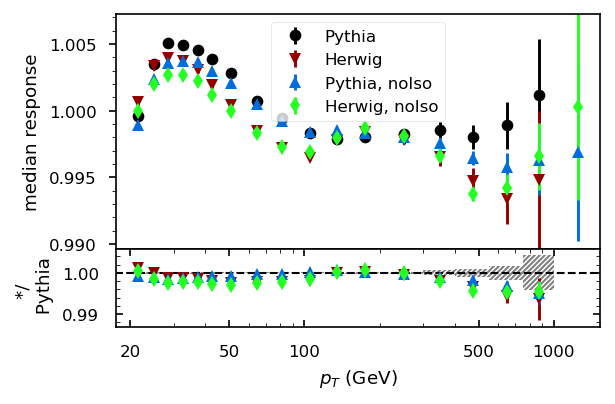

Fitting subsample:  
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


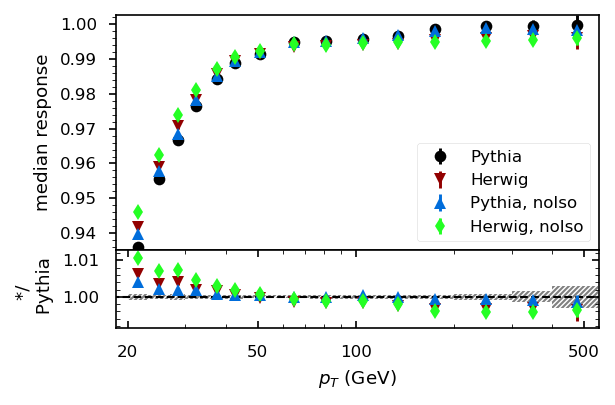

Fitting subsample:  
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


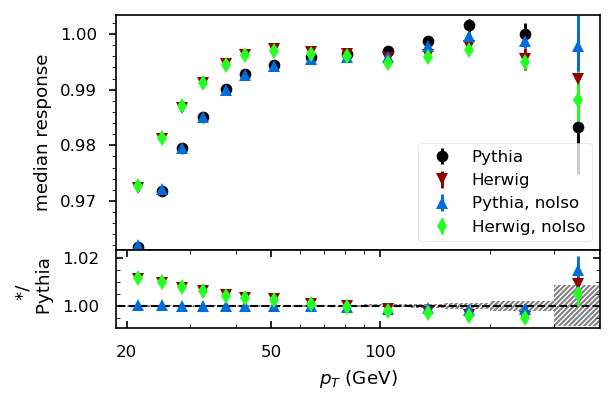

Fitting subsample:  _b
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_b_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


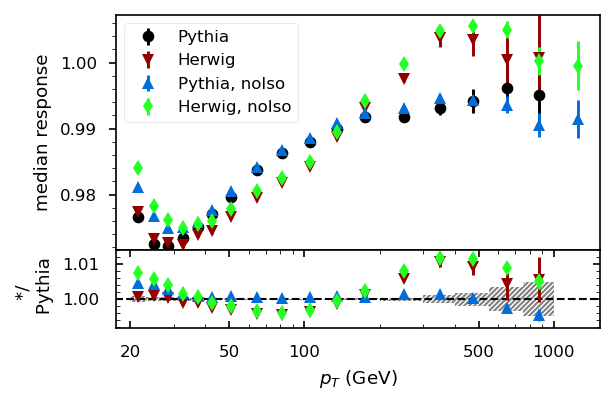

Fitting subsample:  _b
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_b_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


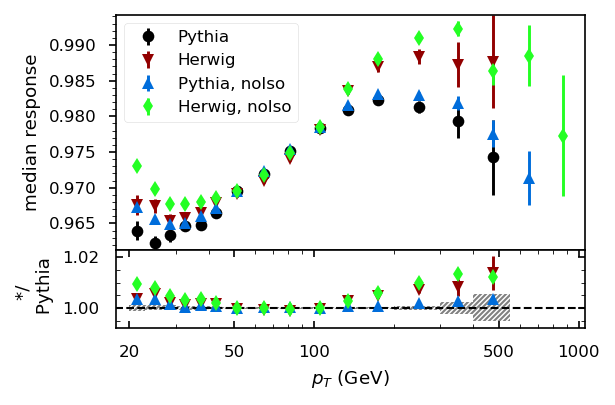

Fitting subsample:  _b
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_b_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


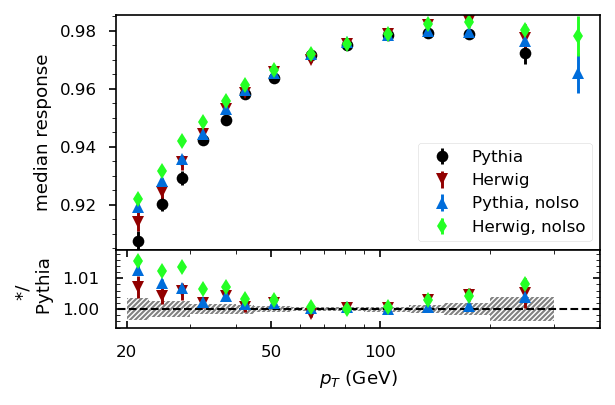

Fitting subsample:  _b
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_b_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


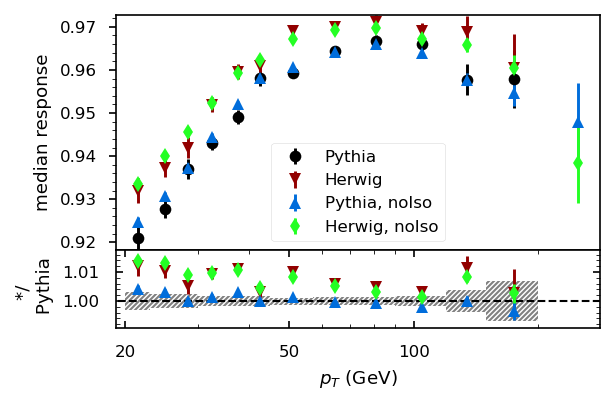

Fitting subsample:  _c
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_c_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


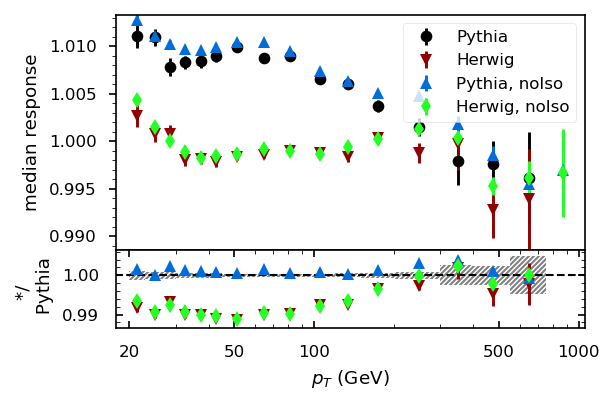

Fitting subsample:  _c
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_c_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


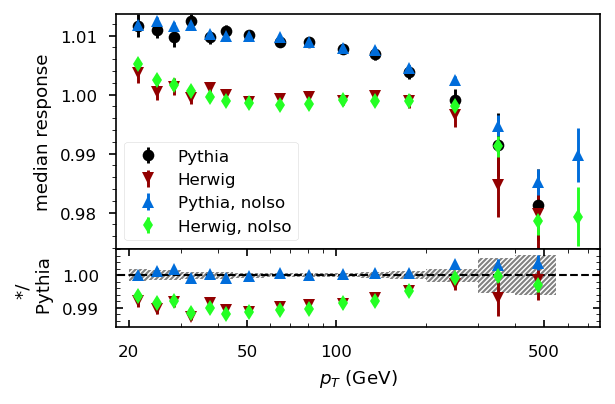

Fitting subsample:  _c
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_c_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


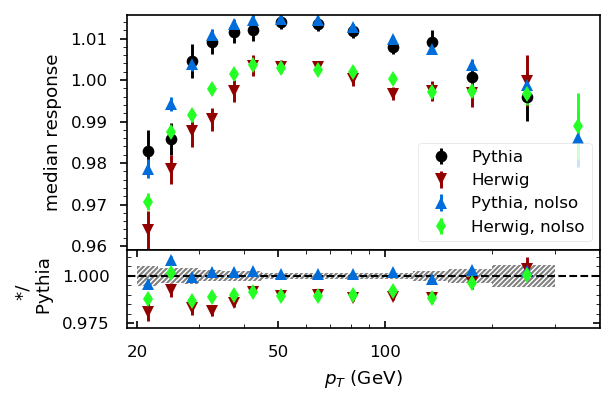

Fitting subsample:  _c
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_c_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


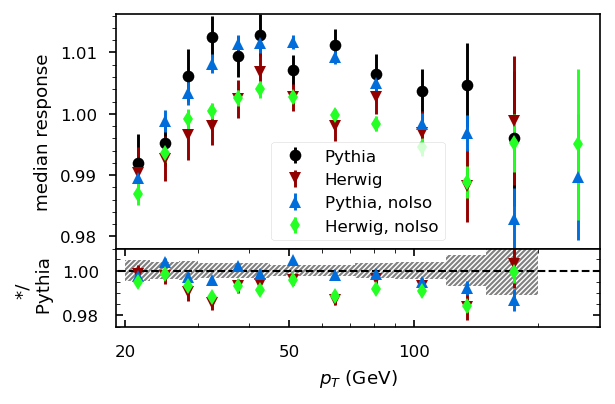

Fitting subsample:  _s
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_s_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


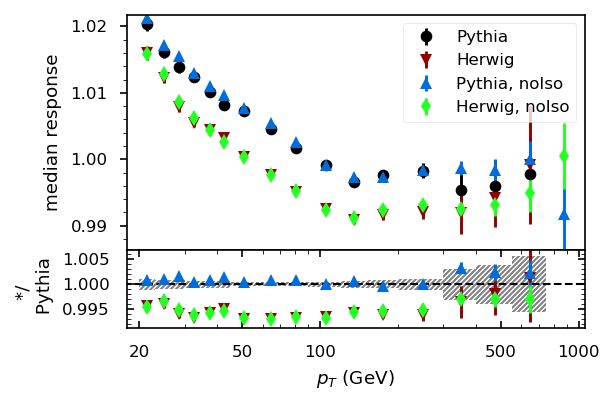

Fitting subsample:  _s
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_s_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


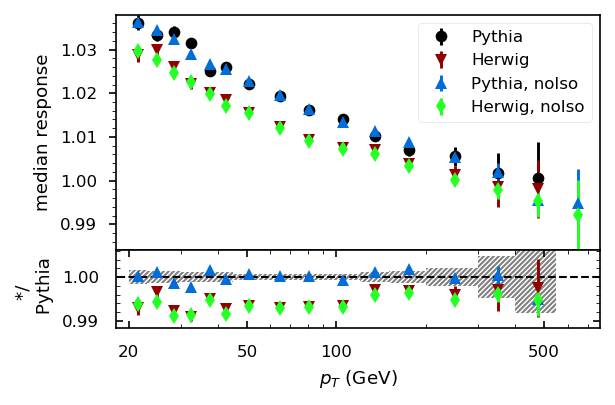

Fitting subsample:  _s
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_s_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


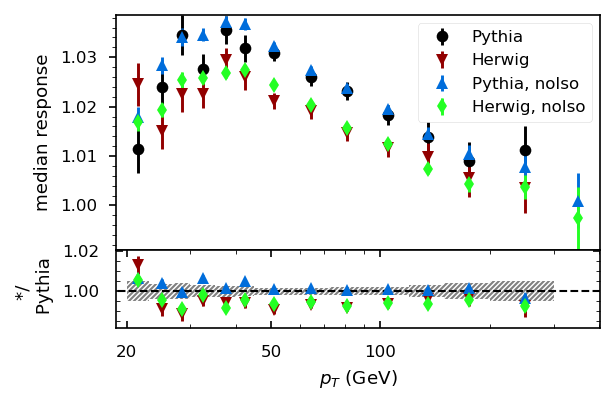

Fitting subsample:  _s
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_s_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


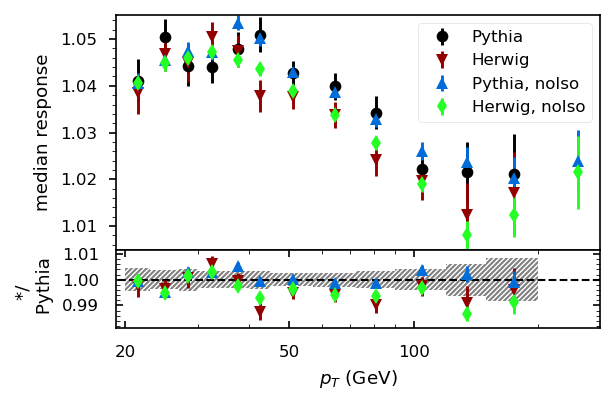

Fitting subsample:  _ud
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_ud_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


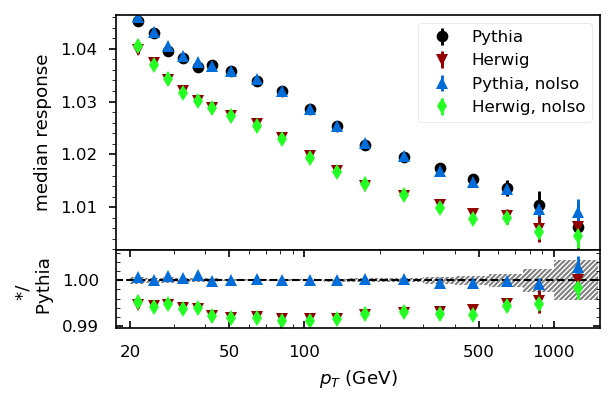

Fitting subsample:  _ud
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_ud_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


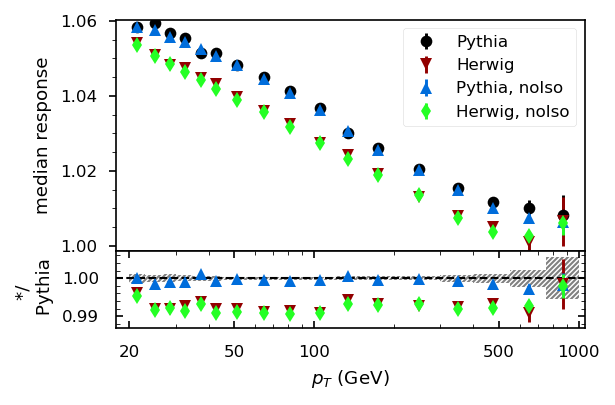

Fitting subsample:  _ud
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_ud_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


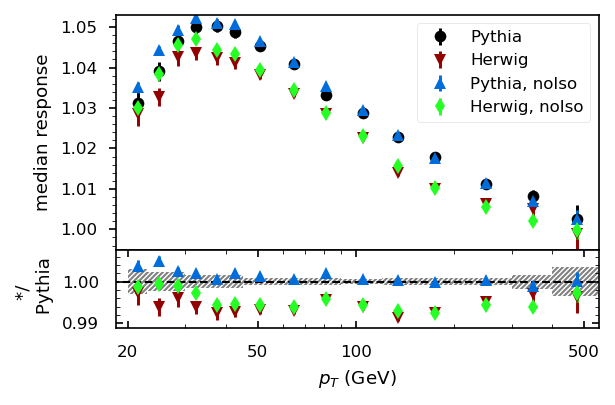

Fitting subsample:  _ud
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_ud_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


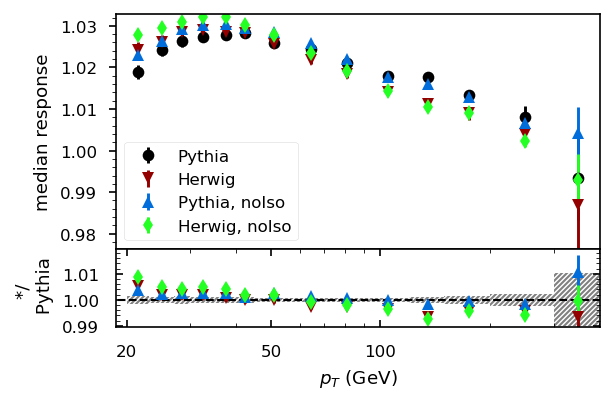

Fitting subsample:  _g
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_g_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


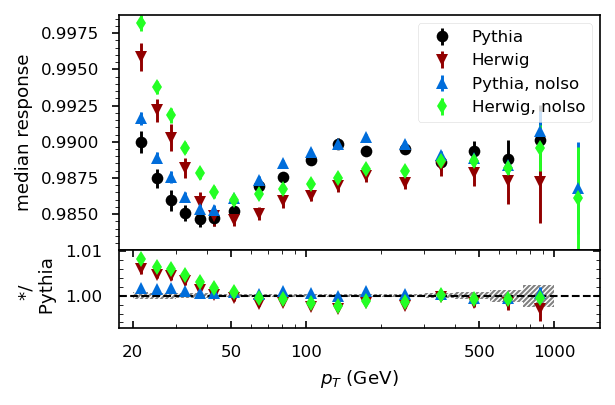

Fitting subsample:  _g
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_g_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


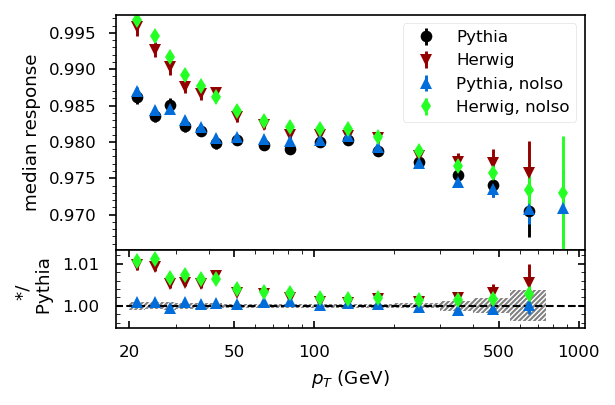

Fitting subsample:  _g
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_g_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


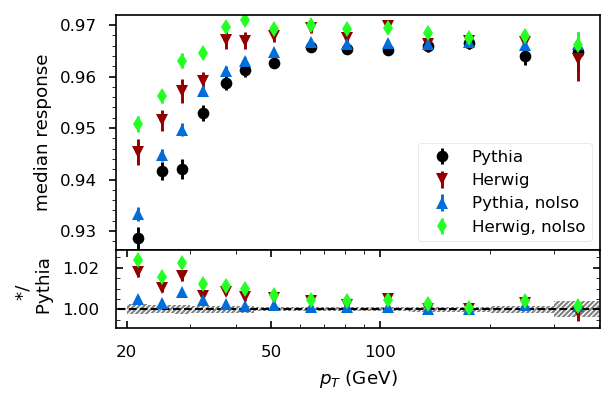

Fitting subsample:  _g
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_g_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


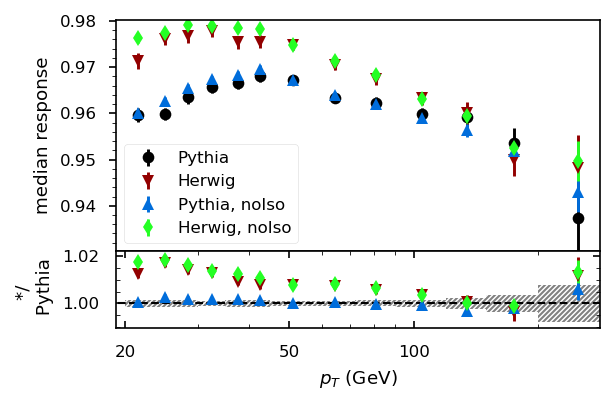

In [21]:
# load_fit_res=True
subsamples = ['', '_b', '_c', '_s', '_ud', '_g']
# subsamples = ['_g']


k2 = np.where(etabins_mod<=0)[0][-1]
k4 = np.where(etabins_mod<=1.3)[0][-1]
k6 = np.where(etabins_mod<=2.5)[0][-1]
k8 = np.where(etabins_mod<=3.0)[0][-1]
ks = [k2, k4, k6, k8]

# ks = [k2, k4] #, k6, k8]
for samp in subsamples:
    for k in ks:
        print('Fitting subsample: ', samp)
        print('Eta: ', k)
        median_QCD = read_data("Median", samp, '_L5_LHEflav1_TTBAR-JME')
        medianstd_QCD = read_data("MedianStd", samp, '_L5_LHEflav1_TTBAR-JME')
        median_TTBAR = read_data("Median", samp, '_L5_LHEflav1_Herwig-TTBAR-JME')
        medianstd_TTBAR = read_data("MedianStd", samp, '_L5_LHEflav1_Herwig-TTBAR-JME')
        median_3 = read_data("Median", samp, '_L5_LHEflav1_TTBAR-JME-Summer16')
        medianstd_3 = read_data("MedianStd", samp, '_L5_LHEflav1_TTBAR-JME-Summer16')
        median_4 = read_data("Median", samp, '_L5_LHEflav1_Herwig-TTBAR-JME-Summer16-cFlip')
        medianstd_4 = read_data("MedianStd", samp, '_L5_LHEflav1_Herwig-TTBAR-JME-Summer16-cFlip')
        
        
        make_comparison_plot_many(median_QCD, medianstd_QCD,
                                  np.array([median_TTBAR, median_3, median_4]),
                                  np.array([medianstd_TTBAR, medianstd_3, medianstd_4]),
                             k, samp, 'Pythia', ['Herwig', 'Pythia, noIso', 'Herwig, noIso'], '*/ \n Pythia')
        
3;

In [8]:
# samp = '_s'

# median_QCD = read_data("Median", samp, '_L5_LHEflav1_TTBAR-JME')
# medianstd_QCD = read_data("MedianStd", samp, '_L5_LHEflav1_TTBAR-JME')
# median_TTBAR = read_data("Median", samp+'bar', '_L5_LHEflav1_TTBAR-JME')
# medianstd_TTBAR = read_data("MedianStd", samp+'bar', '_L5_LHEflav1_TTBAR-JME')
# median_3 = read_data("Median", samp, '_L5_LHEflav1_Herwig-TTBAR-JME')
# medianstd_3 = read_data("MedianStd", samp, '_L5_LHEflav1_Herwig-TTBAR-JME')
# median_4 = read_data("Median", samp+'bar', '_L5_LHEflav1_Herwig-TTBAR-JME')
# medianstd_4 = read_data("MedianStd", samp+'bar', '_L5_LHEflav1_Herwig-TTBAR-JME')

# # yvals_base = median_QCD
# # std_base = medianstd_QCD

# # yvals_ref = median_TTBAR
# # std_ref = medianstd_TTBAR

# # yvals_base2 = median_3
# # std_base2 = medianstd_3

# # yvals_ref2 = median_4
# # std_ref2 = medianstd_4

# # yvars = np.array([median_TTBAR, median_4])
# # stds = np.array([medianstd_TTBAR, medianstd_4])
# base_name = 'Pythia'
# names = ['Pythia, anti flav', 'Pythia, anti', 'Herwig, noIso']
# name_base = ''

In [9]:
# median_QCD
# median_3

In [11]:
# k=0

In [9]:
def make_double_ratio_plot(outputname1, outputname2, k=0, samp='',
                            ratio_name='ratio'):
#     outputname1 = '_L5_LHEflav1_TTBAR-JME'
#     outputname2 = '_L5_LHEflav1_Herwig-TTBAR-JME'
        
    median_1 = read_data("Median", samp, outputname1)
    medianstd_1 = read_data("MedianStd", samp, outputname1)
    median_2 = read_data("Median", samp+'bar', outputname1)
    medianstd_2 = read_data("MedianStd", samp+'bar', outputname1)
    median_3 = read_data("Median", samp, outputname2)
    medianstd_3 = read_data("MedianStd", samp, outputname2)
    median_4 = read_data("Median", samp+'bar', outputname2)
    medianstd_4 = read_data("MedianStd", samp+'bar', outputname2)

        
    yvals_base = median_1
    std_base = medianstd_1

    yvals_ref = median_2
    std_ref = medianstd_2

    yvals_base2 = median_3
    std_base2 = medianstd_3

    yvals_ref2 = median_4
    std_ref2 = medianstd_4


    mean_p_base = yvals_base.copy()
    mean_p_base[(mean_p_base==0) | (np.abs(mean_p_base)==np.inf)] = np.nan

    # mean_ps = []
    # for yvar in yvars:
    #     mean_ps = yvar.copy()

    # yvars[(yvars==0) | (np.abs(yvars)==np.inf)] = np.nan


    # fig = plt.figure()
    # gs = fig.add_gridspec(nrows=1, ncols=1)
    fig, ax2 = plt.subplots();
    # ax2 = fig.add_subplot(gs[1])
    start = np.where(ptbins<=20)[0][-1]

    for axis in [ax2.xaxis, ax2.yaxis]:
        axis.set_minor_locator(mpl.ticker.AutoMinorLocator())

    xvals = (ptbins[start:-1] + ptbins[start+1:])/2
    wd = np.abs(ptbins[start:-1] - ptbins[start+1:])

    yvals_base = mean_p_base[start:,k]
    yvals_base[(yvals_base==0) | (np.abs(yvals_base)==np.inf)] = np.nan
    std_base = std_base[start:,k]

    yvals_ref = yvals_ref[start:,k]
    yvals_ref[(yvals_ref==0) | (np.abs(yvals_ref)==np.inf)] = np.nan
    std_ref = std_ref[start:,k]

    yvals_base2 = yvals_base2[start:,k]
    yvals_base2[(yvals_base2==0) | (np.abs(yvals_base2)==np.inf)] = np.nan
    std_base2 = std_base2[start:,k]


    yvals_ref2 = yvals_ref2[start:,k]
    yvals_ref2[(yvals_ref2==0) | (np.abs(yvals_ref2)==np.inf)] = np.nan
    std_ref2 = std_ref2[start:,k]


    # markers = ['v','^','d', 'p']
    # for val, name, std, marker in zip(yvars, names, stds, markers):
    #     ax.errorbar(xvals, val, yerr=std, marker=marker,
    #                 linestyle="none", label=name)

    rel_mc_unc =  std_base/yvals_base 

    ax2.bar(
        xvals,
        2 * rel_mc_unc,
        width=wd,
        bottom=1.0 - rel_mc_unc,
        fill=False,
        linewidth=0,
        alpha=0.9,
        edgecolor="red",
        hatch=10 * "/",
    )

    rel_mc_unc2 =  std_base2/yvals_base2 

    ax2.bar(
        xvals+0.00001,
        2 * rel_mc_unc2,
        width=wd,
        bottom=1.0 - rel_mc_unc2,
        fill=False,
        linewidth=0,
        alpha=0.5,
        edgecolor="blue",
        hatch=10 * "\\",
    )


    # data in ratio plot
    data_model_ratio = yvals_ref/yvals_base
    data_model_ratio_unc = std_ref / yvals_base

    # for val, std, marker in zip(data_model_ratio, data_model_ratio_unc, markers):
    ax2.errorbar(
        xvals,
        data_model_ratio, #[nonzero_model_yield],
        yerr=data_model_ratio_unc, #[nonzero_model_yield],
        fmt='o',
        label = 'Pythia',
    )

    # data in ratio plot
    data_model_ratio2 = yvals_ref2/yvals_base2
    data_model_ratio_unc2 = std_ref2/ yvals_base2

    ax2.errorbar(
        xvals,
        data_model_ratio2, #[nonzero_model_yield],
        yerr=data_model_ratio_unc2, #[nonzero_model_yield],
        fmt='^',
        label = 'Herwig',
    #     colour='blue'
    )

    ax2.set_ylabel(ratio_name)
    ax2.tick_params(axis="both", which="major", pad=8)
    ax2.tick_params(direction="in", top=True, right=True, which="both")

    fig.set_tight_layout(True)



    # ### Calculate resonable limits excluding the few points with insane errors
    # yerr_norm = np.concatenate([std_base, std_base2 ])
    # y_norm = np.concatenate([vals_base, vals_base2])
    # norm_pos = (yerr_norm<0.04) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    # ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))

    yerr_norm = np.concatenate([rel_mc_unc, rel_mc_unc2, data_model_ratio_unc, data_model_ratio_unc2 ])
    y_norm = np.concatenate([yvals_base/yvals_base, yvals_base2/yvals_base2, data_model_ratio, data_model_ratio2])
    norm_pos = (yerr_norm<0.003) &  (yerr_norm != np.inf) & (y_norm>-0.1)  
    #     if samp == '_b' and k==3:
    #         1/0
    left_lim = np.min((y_norm-yerr_norm)[norm_pos])
    right_lim = np.max((yerr_norm+y_norm)[norm_pos])
    lim_pad = (right_lim - left_lim)/10
    ax2.set_ylim(left_lim-lim_pad, right_lim+lim_pad)

    ax2.set_xlabel(r'$p_T$ (GeV)');
    # ax.set_ylabel(r'median response');
    # ax.set_xscale('log')
    ax2.set_xscale('log')

    # ax.set_xticks([])

    good_xlims = ax2.get_xlim()

    ax2.hlines(1,1, 10000, linestyles='--',color="black",
        linewidth=1,)
    ax2.set_xticks([20, 50, 100, 500, 1000, 5000])
    ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax2.set_xlim(good_xlims)

    leg1 = ax2.legend()


    eta_string = '_eta'+str(etabins_mod[k])+'to'+str(etabins_mod[k+1])
    eta_string = eta_string.replace('.','')
    print("Saving plot for eta = ", eta_string)
    fig_name = 'fig/corr_vs_pt'+samp+eta_string+'_L5_double_ratio'+'-median'
    fig_name = fig_name.replace(', ', '-')
    print("Saving plot with the name = ", fig_name)
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');
    # gs1.tight_layout(fig, rect=[0, 0.1, 0.8, 0.5])
    plt.show();

Fitting subsample:  _b
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_b_eta00to13_L5_double_ratio-median


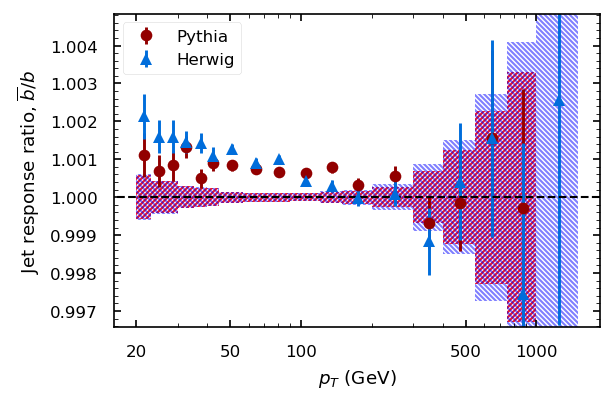

Fitting subsample:  _b
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_b_eta13to25_L5_double_ratio-median


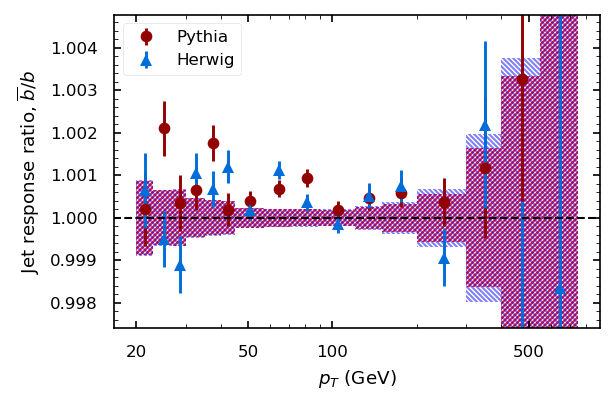

Fitting subsample:  _b
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_b_eta25to30_L5_double_ratio-median


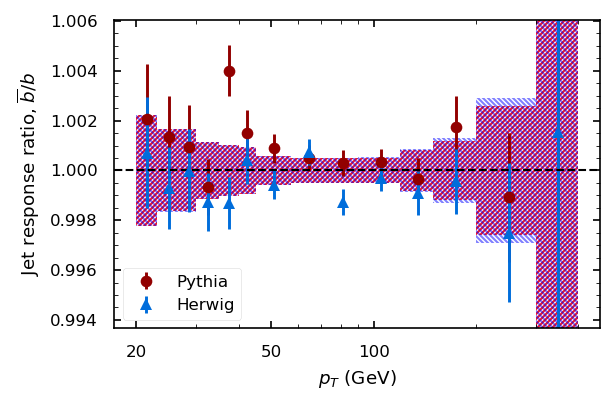

Fitting subsample:  _b
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_b_eta30to50_L5_double_ratio-median


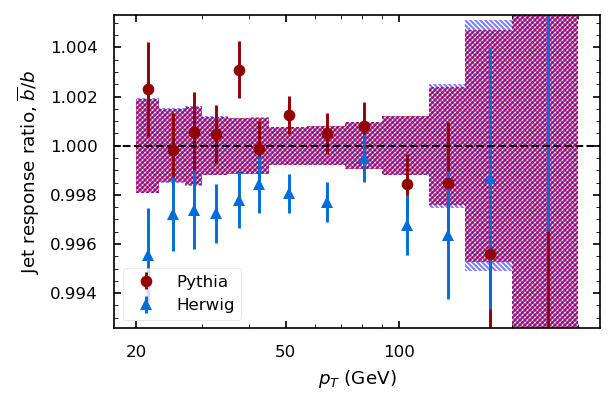

Fitting subsample:  _c
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_c_eta00to13_L5_double_ratio-median


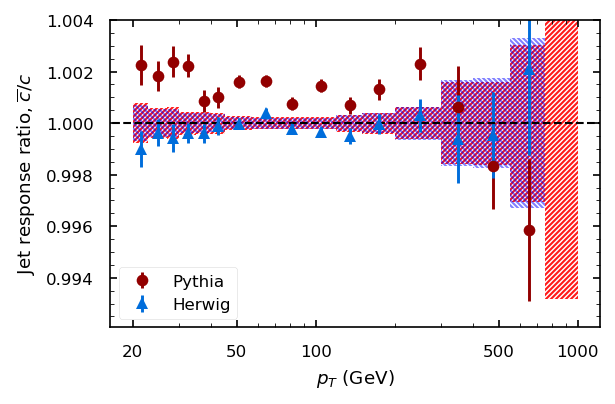

Fitting subsample:  _c
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_c_eta13to25_L5_double_ratio-median


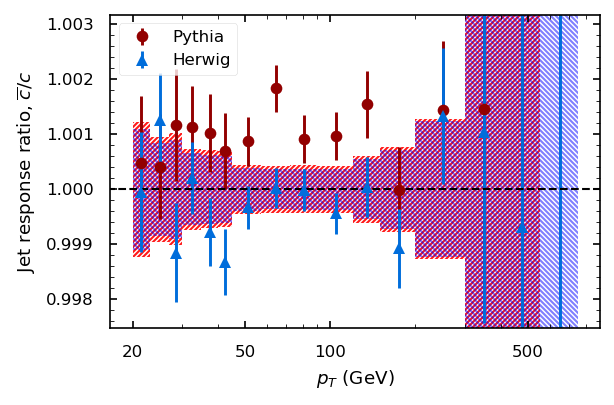

Fitting subsample:  _c
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_c_eta25to30_L5_double_ratio-median


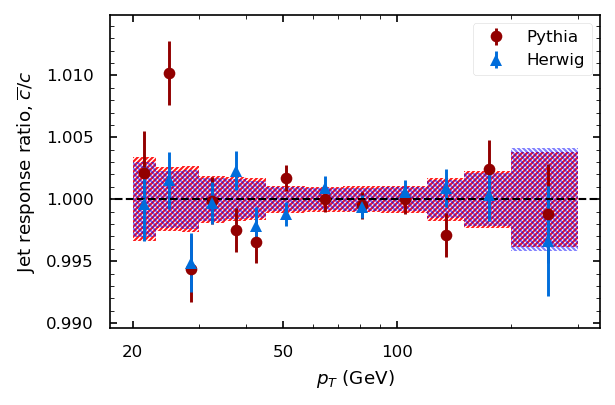

Fitting subsample:  _c
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_c_eta30to50_L5_double_ratio-median


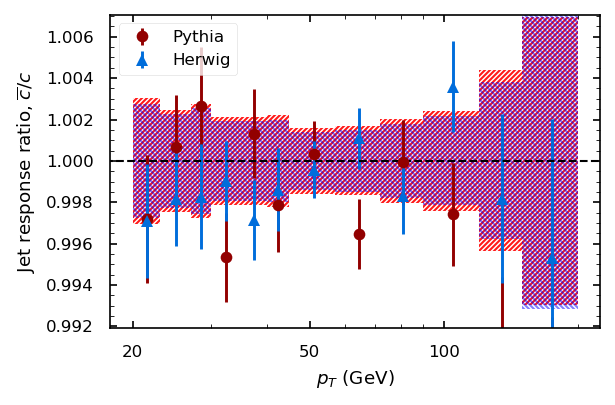

Fitting subsample:  _s
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_s_eta00to13_L5_double_ratio-median


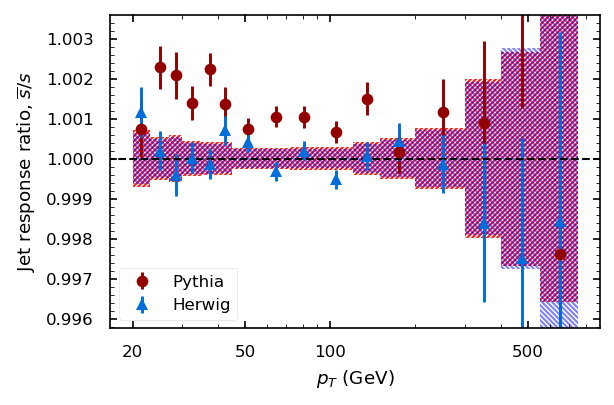

Fitting subsample:  _s
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_s_eta13to25_L5_double_ratio-median


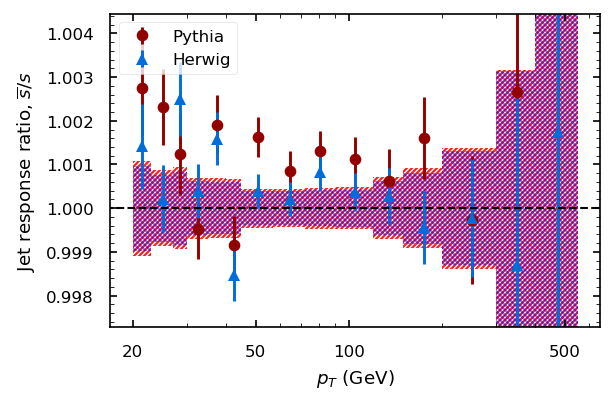

Fitting subsample:  _s
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_s_eta25to30_L5_double_ratio-median


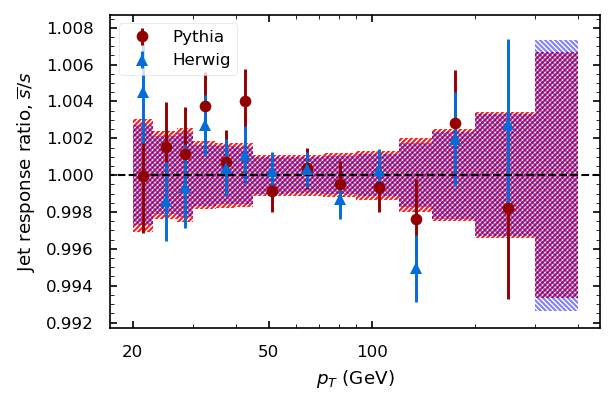

Fitting subsample:  _s
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_s_eta30to50_L5_double_ratio-median


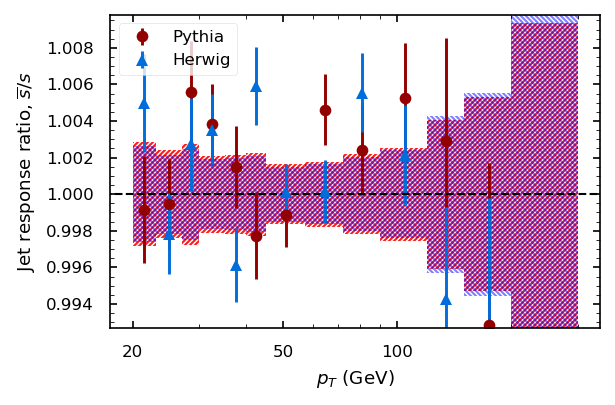

Fitting subsample:  _u
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_u_eta00to13_L5_double_ratio-median


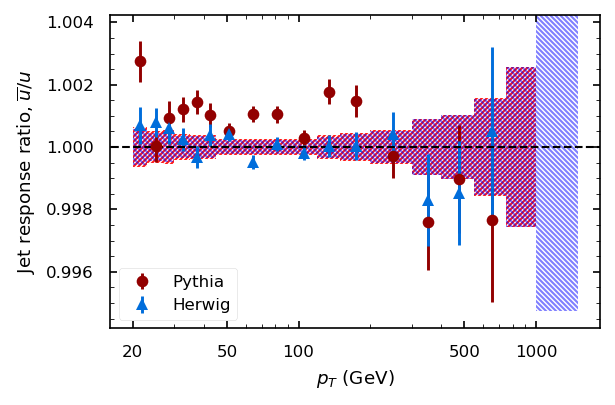

Fitting subsample:  _u
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_u_eta13to25_L5_double_ratio-median


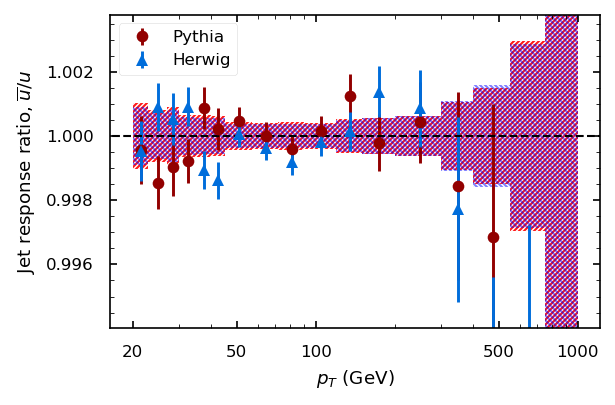

Fitting subsample:  _u
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_u_eta25to30_L5_double_ratio-median


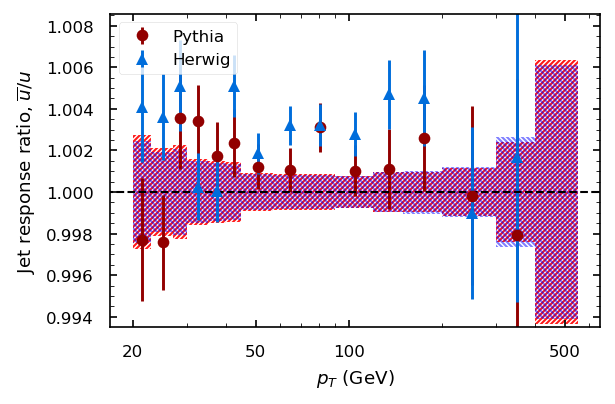

Fitting subsample:  _u
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_u_eta30to50_L5_double_ratio-median


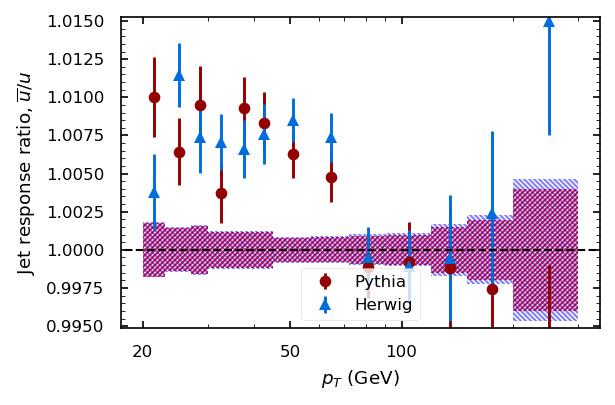

Fitting subsample:  _d
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_d_eta00to13_L5_double_ratio-median


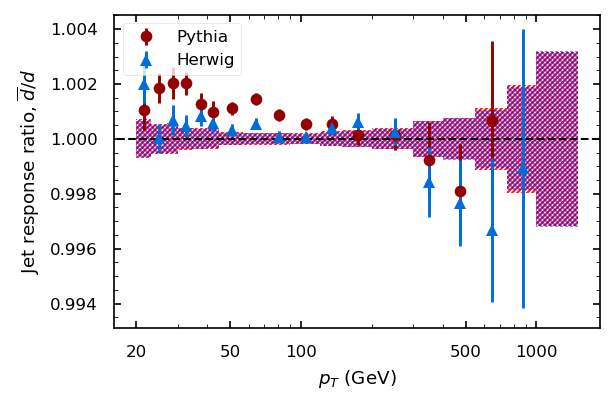

Fitting subsample:  _d
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_d_eta13to25_L5_double_ratio-median


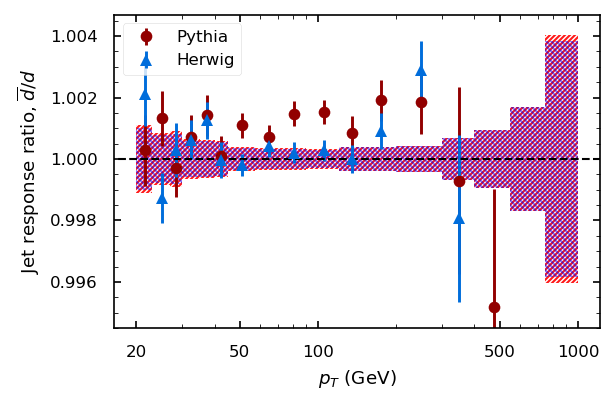

Fitting subsample:  _d
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_d_eta25to30_L5_double_ratio-median


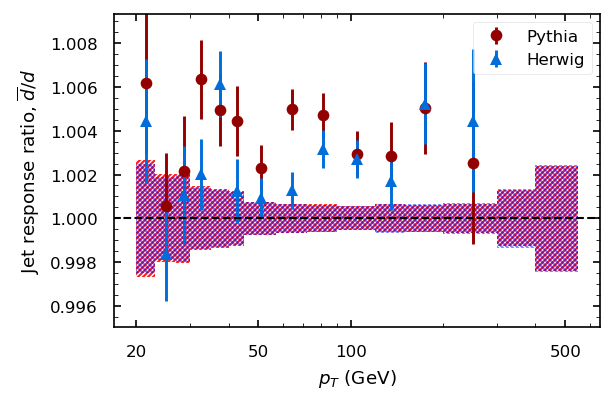

Fitting subsample:  _d
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_d_eta30to50_L5_double_ratio-median


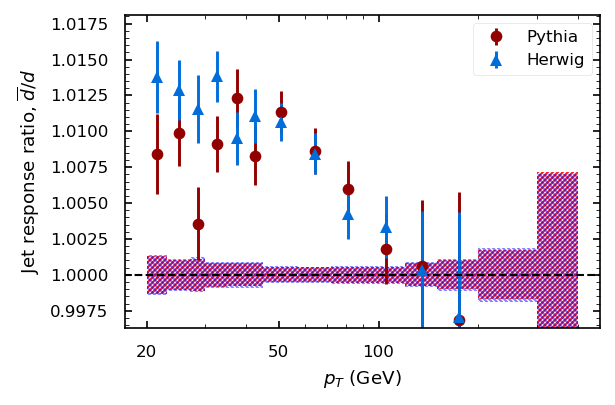

In [11]:
# load_fit_res=True
subsamples = ['_b', '_c', '_s', '_u', '_d']
# subsamples = ['_b']

k2 = np.where(etabins_mod<=0)[0][-1]
k4 = np.where(etabins_mod<=1.3)[0][-1]
k6 = np.where(etabins_mod<=2.5)[0][-1]
k8 = np.where(etabins_mod<=3.0)[0][-1]
ks = [k2, k4, k6, k8]

# ks = [k2, k4] #, k6, k8]
for samp in subsamples:
    for k in ks:
        print('Fitting subsample: ', samp)
        print('Eta: ', k)        
        
        make_double_ratio_plot('_L5_LHEflav1_TTBAR-JME-100files', '_L5_LHEflav1_Herwig-TTBAR-JME-100files',
                                   k=k, samp=samp,
                                   ratio_name='Jet response ratio, $\overline{'+samp[1:]+'}/'+samp[1:]+'$')
                
3;

Fitting subsample:  _b
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_b_eta00to13_L5_double_ratio-median


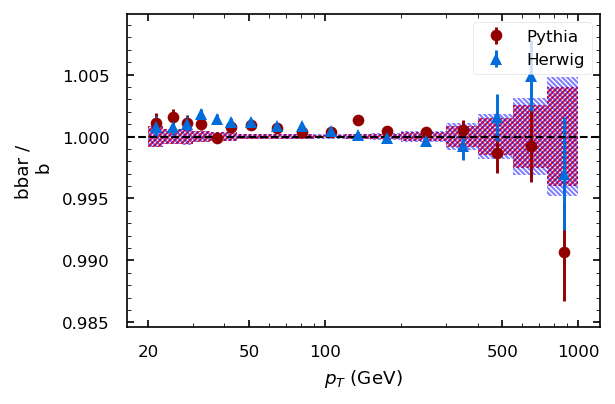

Fitting subsample:  _b
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_b_eta13to25_L5_double_ratio-median


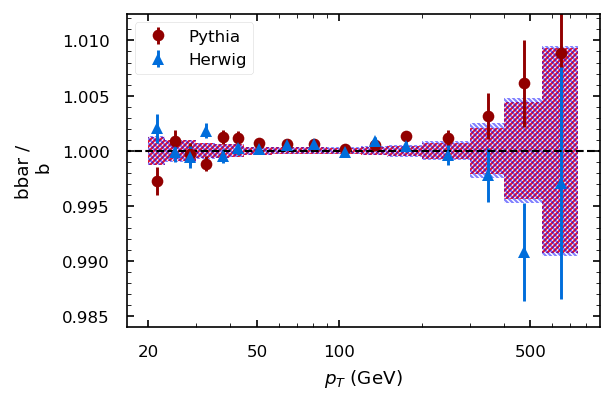

Fitting subsample:  _b
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_b_eta25to30_L5_double_ratio-median


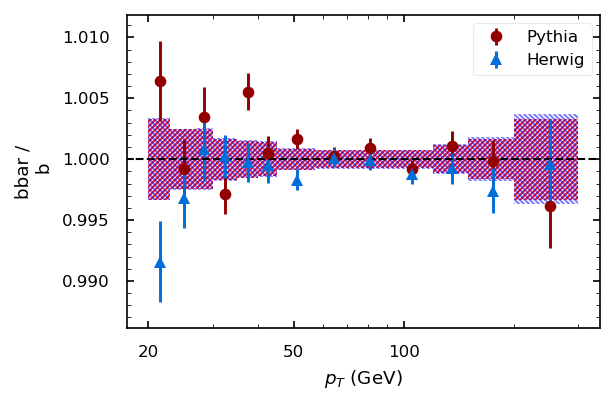

Fitting subsample:  _b
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_b_eta30to50_L5_double_ratio-median


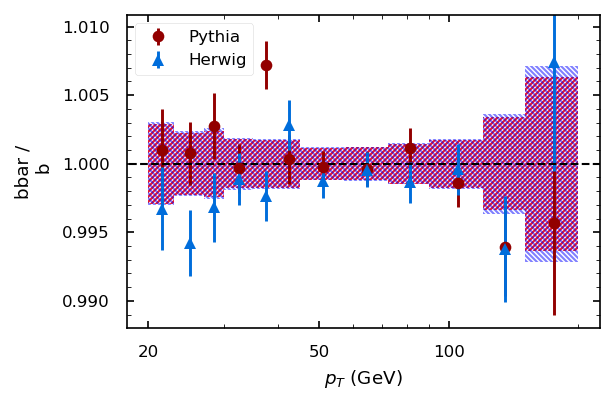

Fitting subsample:  _c
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_c_eta00to13_L5_double_ratio-median


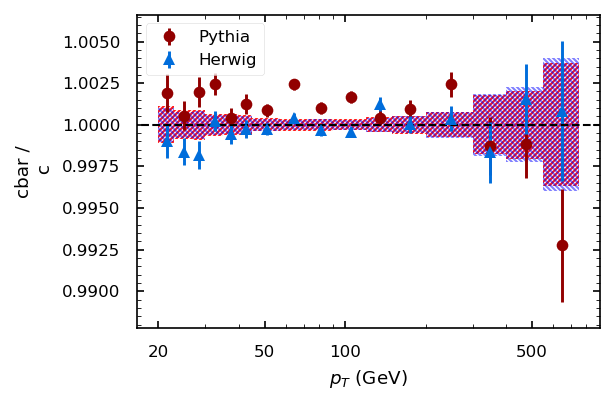

Fitting subsample:  _c
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_c_eta13to25_L5_double_ratio-median


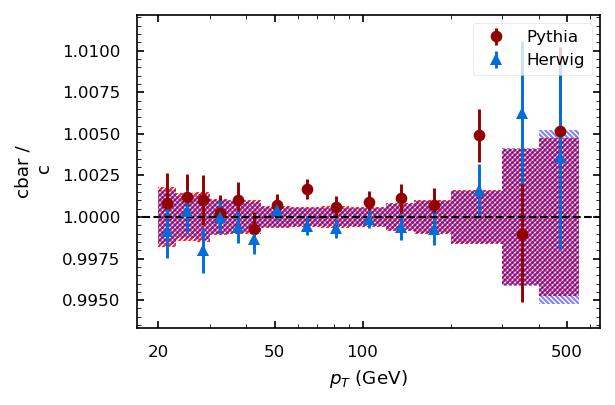

Fitting subsample:  _c
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_c_eta25to30_L5_double_ratio-median


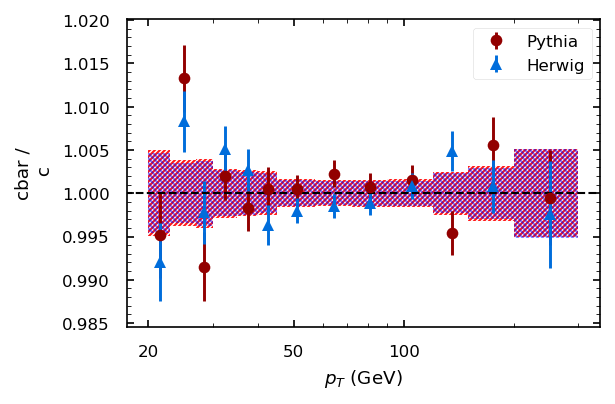

Fitting subsample:  _c
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_c_eta30to50_L5_double_ratio-median


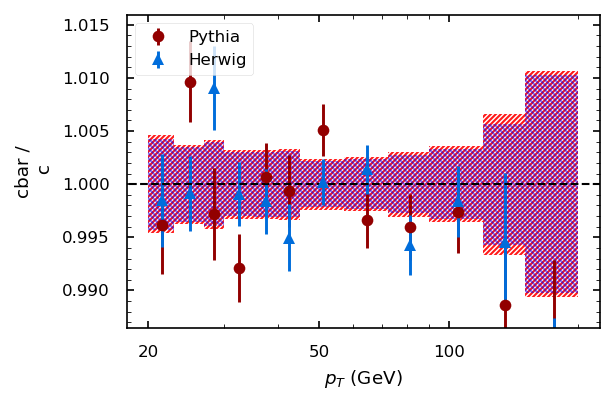

Fitting subsample:  _s
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_s_eta00to13_L5_double_ratio-median


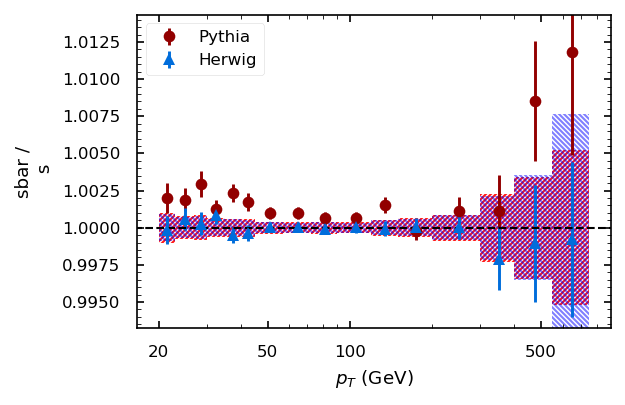

Fitting subsample:  _s
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_s_eta13to25_L5_double_ratio-median


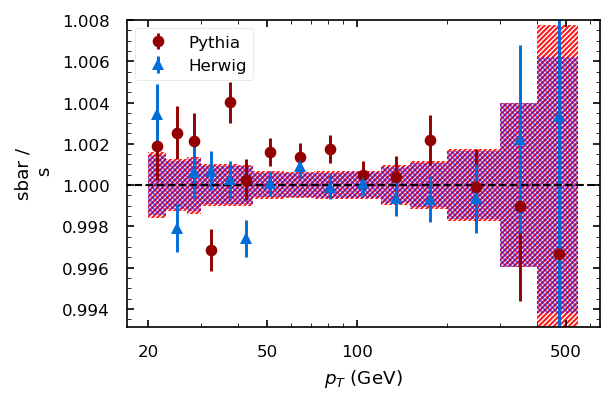

Fitting subsample:  _s
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_s_eta25to30_L5_double_ratio-median


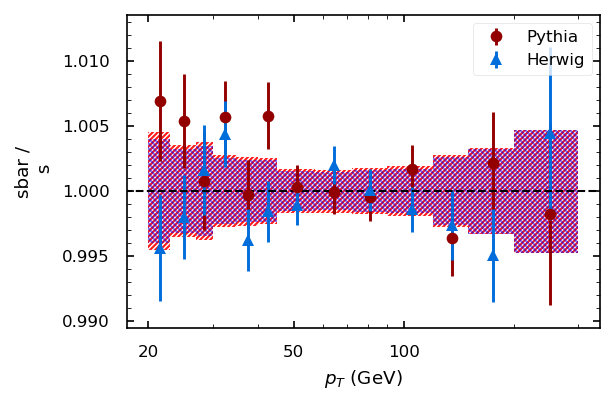

Fitting subsample:  _s
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_s_eta30to50_L5_double_ratio-median


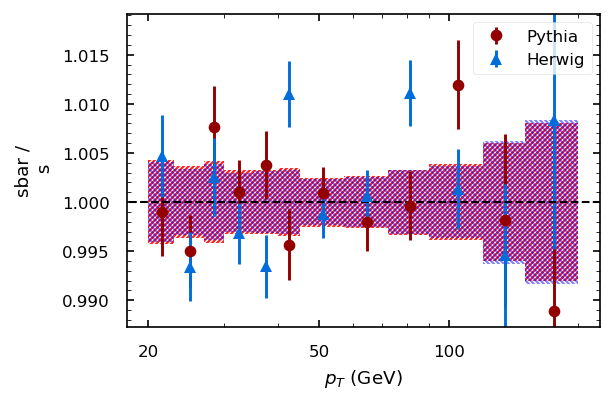

Fitting subsample:  _ud
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_ud_eta00to13_L5_double_ratio-median


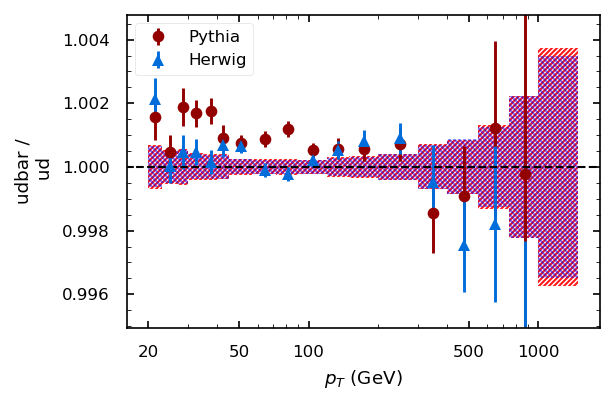

Fitting subsample:  _ud
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_ud_eta13to25_L5_double_ratio-median


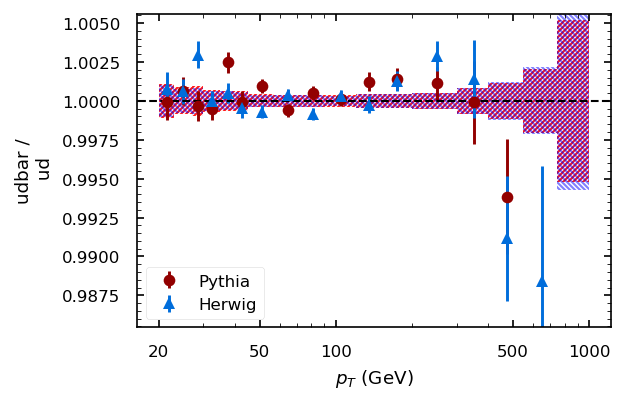

Fitting subsample:  _ud
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_ud_eta25to30_L5_double_ratio-median


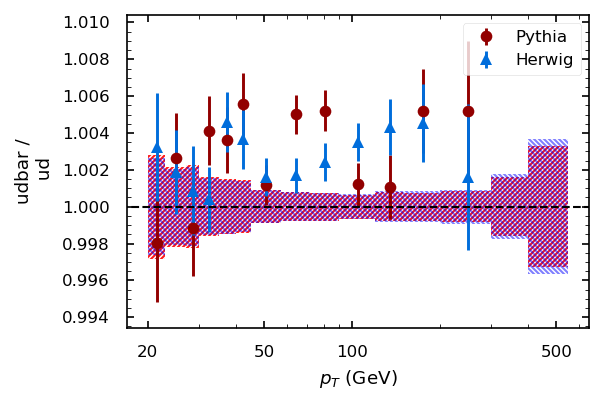

Fitting subsample:  _ud
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_ud_eta30to50_L5_double_ratio-median


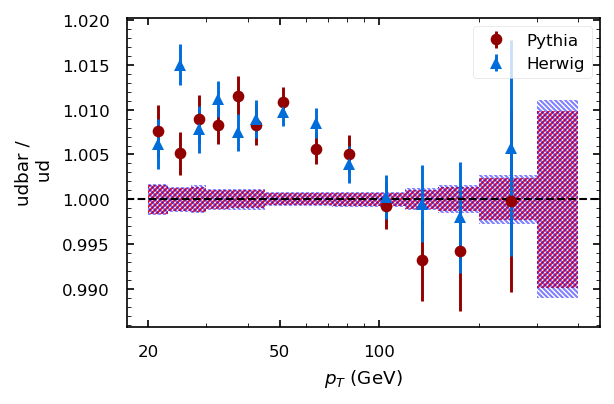

In [134]:
# load_fit_res=True
subsamples = ['_b', '_c', '_s', '_ud']
# subsamples = ['_g']

k2 = np.where(etabins_mod<=0)[0][-1]
k4 = np.where(etabins_mod<=1.3)[0][-1]
k6 = np.where(etabins_mod<=2.5)[0][-1]
k8 = np.where(etabins_mod<=3.0)[0][-1]
ks = [k2, k4, k6, k8]

# ks = [k2, k4] #, k6, k8]
for samp in subsamples:
    for k in ks:
        print('Fitting subsample: ', samp)
        print('Eta: ', k)        
        
        make_double_ratio_plot('_L5_LHEflav1_TTBAR-JME', '_L5_LHEflav1_Herwig-TTBAR-JME',
                                   k=k, samp=samp,
                                   ratio_name=f'{samp[1:]}bar /\n {samp[1:]}')
                
3;

In [57]:
good_xlims

(11.0, 209.0)